# <font color ='blue'>Zillow Clustering Project - Working Copy
    
<img src="zillow_logo.png" alt="Zillow Logo" title="Zillow Logo" width="300" height="100" align="right"/>
    
    
# <p style="font-size:50px" align="center">Zestimate Error</p> <sub>By Kaniela Denis - 13 Dec 2021</sub>

In [1]:
# import pandas and numpy to start coding
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# prep methods
from sklearn.model_selection import train_test_split

# Scaler
from sklearn.preprocessing import MinMaxScaler

# cluster method
from sklearn.cluster import KMeans

# Feature Engineering methods
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing

# Modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


import warnings
warnings.filterwarnings("ignore")

<hr style="border:2px solid blue"> </hr>

# <font color = 'red'>Planning

### Project Goals

- Predict logerror of Zestimate
- Discover the drivers of the error in the Zcestimate
- Compare four different clustering models
- Conclude if clustering helps with discovering drivers
- 


- A model that predicts property tax assessed values of single family properties based on 2017 transactions.
- Identify ways to make a better model for Zillow.
- Create new features out of existing features.
- Try non-linear regression model or try a model for each county.


### Project Description

Deliver:
1. Github Repo
    - README.md
    - Final Report
    - Working Notebook
    - Modules (Acquire, Prepare, Model)
    - Misc Artifacts
2. Further Requirements:
    - Aquistion:
        - SQL Query
    - Prep:
        - Columns have appropriate Data Types
        - Missing values and Outliers are investigated/handled
    - Explore:
        - Use vizulization and statistical testing for target/independ variable interations
        - Clustering is used to explore the data. Minumum of 3 combinations of features tried. A conclusion is made on whether clustering helped, supported by visualizations and statistical testing.
    - Clustering:
        - 3 different combos
    - Modeling: 
        - Minimum 4 different models created and performance compared
3. Final Notebook with Recommendation
    - 4 Visuals, 2 with stats tests
        - Data Context of Target Variable (Distribution of values)
    - 3 Best Models (show steps/code to fit/eval/select)
    - Visual of how best Model performed
4. Working Notebook:
    - Reproducible comments
    - Exploration with at least two stats test during exploration
5. Presentation
    - Findings
    - Methodologies
    - Conclusions

### Initial Questions

- Which county has the most log error?
- Which tax rate has the most log error?
- What combinatin of bedroom and bathroom has the most log error?
- What tax value has the most log error?
- Is log error associated to house size?
- Is log error associated to lot size?

### Data Dictionary (Add to README)

In [2]:
# Read Data Dictionary from working directory
dd = pd.read_excel('zillow_data_dictionary.xlsx')

In [3]:
## References are available on my GitHub 

In [4]:
#[click me](https://github.com/kanieladenis/zillow_regression_project)

# <font color = 'red'> Acquisition (Get and Clean Data)

## <font color = 'red'>Get Data

- Added env.py to the repo .gitignore file so env.py won't be pushed to github
- Created an env file that contains my username, password, and host address fo the MySQL Server.

In [5]:
# import env file for hostname, username, password, and db_name
from env import host, user, password, db_name

In [6]:
# Pass env file authentication to container 'url'
url = f'mysql+pymysql://{user}:{password}@{host}/{db_name}'

### Pull records of houses with transactions from 2017

In [7]:
# define sql search for all records from all tables
sql = """
SELECT *
FROM properties_2017
LEFT JOIN predictions_2017 pred USING(parcelid)
LEFT JOIN airconditioningtype USING(airconditioningtypeid)
LEFT JOIN architecturalstyletype USING(architecturalstyletypeid)
LEFT JOIN buildingclasstype USING(buildingclasstypeid)
LEFT JOIN heatingorsystemtype USING(heatingorsystemtypeid)
LEFT JOIN propertylandusetype USING(propertylandusetypeid)
LEFT JOIN storytype USING(storytypeid)
LEFT JOIN typeconstructiontype USING(typeconstructiontypeid)
WHERE latitude IS NOT NULL 
AND longitude IS NOT NULL
AND propertylandusetypeid = 261
AND transactiondate LIKE "2017%%"
AND pred.id IN (SELECT MAX(id)
FROM predictions_2017
GROUP BY parcelid
HAVING MAX(transactiondate))
"""

### Note:
- ????

### Create Dataframe

In [8]:
# load zillow data from saved csv or pull from sql server and save to csv
import os
file = 'zillow_data.csv'
if os.path.isfile(file):
    df = pd.read_csv(file, index_col=0)
else:
    df = pd.read_sql(sql,url)
    df.to_csv(file)
df.head()

typeconstructiontypeid  storytypeid  propertylandusetypeid  \
0                     NaN          NaN                  261.0   
1                     NaN          NaN                  261.0   
2                     NaN          NaN                  261.0   
3                     NaN          NaN                  261.0   
4                     NaN          NaN                  261.0   

   heatingorsystemtypeid  buildingclasstypeid  architecturalstyletypeid  \
0                    NaN                  NaN                       NaN   
1                    NaN                  NaN                       NaN   
2                    NaN                  NaN                       NaN   
3                    2.0                  NaN                       NaN   
4                    2.0                  NaN                       NaN   

   airconditioningtypeid  parcelid       id  basementsqft  ...  id.1  \
0                    NaN  14297519  1727539           NaN  ...     0   
1                    NaN  17052889  1387261           NaN  ...     1   
2                    NaN  14186244    11677           NaN  ...     2   
3                    NaN  12177905  2288172           NaN  ...     3   
4                    1.0  12095076   781532           NaN  ...     6   

   logerror  transactiondate  airconditioningdesc  architecturalstyledesc  \
0  0.025595       2017-01-01                  NaN                     NaN   
1  0.055619       2017-01-01                  NaN                     NaN   
2  0.005383       2017-01-01                  NaN                     NaN   
3 -0.103410       2017-01-01                  NaN                     NaN   
4 -0.001011       2017-01-01              Central                     NaN   

   buildingclassdesc  heatingorsystemdesc        propertylandusedesc  \
0                NaN                  NaN  Single Family Residential   
1                NaN                  NaN  Single Family Residential   
2                NaN                  NaN  Single Family Residential   
3                NaN              Central  Single Family Residential   
4                NaN              Central  Single Family Residential   

   storydesc  typeconstructiondesc  
0        NaN                   NaN  
1        NaN                   NaN  
2        NaN                   NaN  
3        NaN                   NaN  
4        NaN                   NaN  

[5 rows x 69 columns]

In [9]:
def acquire_zillow():
    # import env file for hostname, username, password, and db_name
    from env import host, user, password, db_name

    # Pass env file authentication to container 'url'
    url = f'mysql+pymysql://{user}:{password}@{host}/{db_name}'

    # define sql search for all records from all tables
    sql = """
    SELECT *
    FROM properties_2017
    LEFT JOIN predictions_2017 pred USING(parcelid)
    LEFT JOIN airconditioningtype USING(airconditioningtypeid)
    LEFT JOIN architecturalstyletype USING(architecturalstyletypeid)
    LEFT JOIN buildingclasstype USING(buildingclasstypeid)
    LEFT JOIN heatingorsystemtype USING(heatingorsystemtypeid)
    LEFT JOIN propertylandusetype USING(propertylandusetypeid)
    LEFT JOIN storytype USING(storytypeid)
    LEFT JOIN typeconstructiontype USING(typeconstructiontypeid)
    WHERE latitude IS NOT NULL 
    AND longitude IS NOT NULL
    AND propertylandusetypeid = 261
    AND transactiondate LIKE "2017%%"
    AND pred.id IN (SELECT MAX(id)
    FROM predictions_2017
    GROUP BY parcelid
    HAVING MAX(transactiondate))
    """

    # load zillow data from saved csv or pull from sql server and save to csv
    import os
    file = 'zillow_data.csv'
    if os.path.isfile(file):
        df = pd.read_csv(file, index_col=0)
    else:
        df = pd.read_sql(sql,url)
        df.to_csv(file)
    return df

In [10]:
df = acquire_zillow()
df.head()

typeconstructiontypeid  storytypeid  propertylandusetypeid  \
0                     NaN          NaN                  261.0   
1                     NaN          NaN                  261.0   
2                     NaN          NaN                  261.0   
3                     NaN          NaN                  261.0   
4                     NaN          NaN                  261.0   

   heatingorsystemtypeid  buildingclasstypeid  architecturalstyletypeid  \
0                    NaN                  NaN                       NaN   
1                    NaN                  NaN                       NaN   
2                    NaN                  NaN                       NaN   
3                    2.0                  NaN                       NaN   
4                    2.0                  NaN                       NaN   

   airconditioningtypeid  parcelid       id  basementsqft  ...  id.1  \
0                    NaN  14297519  1727539           NaN  ...     0   
1                    NaN  17052889  1387261           NaN  ...     1   
2                    NaN  14186244    11677           NaN  ...     2   
3                    NaN  12177905  2288172           NaN  ...     3   
4                    1.0  12095076   781532           NaN  ...     6   

   logerror  transactiondate  airconditioningdesc  architecturalstyledesc  \
0  0.025595       2017-01-01                  NaN                     NaN   
1  0.055619       2017-01-01                  NaN                     NaN   
2  0.005383       2017-01-01                  NaN                     NaN   
3 -0.103410       2017-01-01                  NaN                     NaN   
4 -0.001011       2017-01-01              Central                     NaN   

   buildingclassdesc  heatingorsystemdesc        propertylandusedesc  \
0                NaN                  NaN  Single Family Residential   
1                NaN                  NaN  Single Family Residential   
2                NaN                  NaN  Single Family Residential   
3                NaN              Central  Single Family Residential   
4                NaN              Central  Single Family Residential   

   storydesc  typeconstructiondesc  
0        NaN                   NaN  
1        NaN                   NaN  
2        NaN                   NaN  
3        NaN                   NaN  
4        NaN                   NaN  

[5 rows x 69 columns]

In [11]:
df.shape

(52319, 69)

In [12]:
df.isna().sum().values.sum()

1722350

### Show df info()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52318
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        76 non-null     float64
 1   storytypeid                   47 non-null     float64
 2   propertylandusetypeid         52319 non-null  float64
 3   heatingorsystemtypeid         33849 non-null  float64
 4   buildingclasstypeid           0 non-null      float64
 5   architecturalstyletypeid      70 non-null     float64
 6   airconditioningtypeid         13615 non-null  float64
 7   parcelid                      52319 non-null  int64  
 8   id                            52319 non-null  int64  
 9   basementsqft                  47 non-null     float64
 10  bathroomcnt                   52319 non-null  float64
 11  bedroomcnt                    52319 non-null  float64
 12  buildingqualitytypeid         33654 non-null  float64
 13  c

In [14]:
# df shape
df.shape

(52319, 69)

In [15]:
# Show duplicated observations even with SQL filter
df.parcelid.duplicated().sum()

0

In [16]:
# Sort df by parcelid and then by transaction date to group by parcelid and to make sure transaction date is last
df = df.sort_values(by=['parcelid','transactiondate'])
df.head()

typeconstructiontypeid  storytypeid  propertylandusetypeid  \
37107                     NaN          NaN                  261.0   
48127                     NaN          NaN                  261.0   
15458                     NaN          NaN                  261.0   
12040                     NaN          NaN                  261.0   
13593                     NaN          NaN                  261.0   

       heatingorsystemtypeid  buildingclasstypeid  architecturalstyletypeid  \
37107                    2.0                  NaN                       NaN   
48127                    2.0                  NaN                       NaN   
15458                    2.0                  NaN                       NaN   
12040                    2.0                  NaN                       NaN   
13593                    2.0                  NaN                       NaN   

       airconditioningtypeid  parcelid       id  basementsqft  ...   id.1  \
37107                    NaN  10711855  1087254           NaN  ...  55006   
48127                    1.0  10711877  1072280           NaN  ...  71382   
15458                    1.0  10711888  1340933           NaN  ...  23209   
12040                    NaN  10711910  1878109           NaN  ...  18017   
13593                    NaN  10711923  2190858           NaN  ...  20378   

       logerror  transactiondate  airconditioningdesc  architecturalstyledesc  \
37107 -0.007357       2017-07-07                  NaN                     NaN   
48127  0.021066       2017-08-29              Central                     NaN   
15458  0.077174       2017-04-04              Central                     NaN   
12040 -0.041238       2017-03-17                  NaN                     NaN   
13593 -0.009496       2017-03-24                  NaN                     NaN   

       buildingclassdesc  heatingorsystemdesc        propertylandusedesc  \
37107                NaN              Central  Single Family Residential   
48127                NaN              Central  Single Family Residential   
15458                NaN              Central  Single Family Residential   
12040                NaN              Central  Single Family Residential   
13593                NaN              Central  Single Family Residential   

       storydesc  typeconstructiondesc  
37107        NaN                   NaN  
48127        NaN                   NaN  
15458        NaN                   NaN  
12040        NaN                   NaN  
13593        NaN                   NaN  

[5 rows x 69 columns]

In [17]:
# Show duplicated parcel id
df[df.duplicated(subset='parcelid', keep=False)].head()

Empty DataFrame
Columns: [typeconstructiontypeid, storytypeid, propertylandusetypeid, heatingorsystemtypeid, buildingclasstypeid, architecturalstyletypeid, airconditioningtypeid, parcelid, id, basementsqft, bathroomcnt, bedroomcnt, buildingqualitytypeid, calculatedbathnbr, decktypeid, finishedfloor1squarefeet, calculatedfinishedsquarefeet, finishedsquarefeet12, finishedsquarefeet13, finishedsquarefeet15, finishedsquarefeet50, finishedsquarefeet6, fips, fireplacecnt, fullbathcnt, garagecarcnt, garagetotalsqft, hashottuborspa, latitude, longitude, lotsizesquarefeet, poolcnt, poolsizesum, pooltypeid10, pooltypeid2, pooltypeid7, propertycountylandusecode, propertyzoningdesc, rawcensustractandblock, regionidcity, regionidcounty, regionidneighborhood, regionidzip, roomcnt, threequarterbathnbr, unitcnt, yardbuildingsqft17, yardbuildingsqft26, yearbuilt, numberofstories, fireplaceflag, structuretaxvaluedollarcnt, taxvaluedollarcnt, assessmentyear, landtaxvaluedollarcnt, taxamount, taxdelinquencyflag, taxdelinquencyyear, censustractandblock, id.1, logerror, transactiondate, airconditioningdesc, architecturalstyledesc, buildingclassdesc, heatingorsystemdesc, propertylandusedesc, storydesc, typeconstructiondesc]
Index: []

[0 rows x 69 columns]

In [18]:
# drop dulicates  but keep last transaction date
df = df.drop_duplicates(subset='parcelid', keep='last')

In [19]:
# Show duplicated parcel id
df[df.duplicated(subset='parcelid', keep=False)].head()

Empty DataFrame
Columns: [typeconstructiontypeid, storytypeid, propertylandusetypeid, heatingorsystemtypeid, buildingclasstypeid, architecturalstyletypeid, airconditioningtypeid, parcelid, id, basementsqft, bathroomcnt, bedroomcnt, buildingqualitytypeid, calculatedbathnbr, decktypeid, finishedfloor1squarefeet, calculatedfinishedsquarefeet, finishedsquarefeet12, finishedsquarefeet13, finishedsquarefeet15, finishedsquarefeet50, finishedsquarefeet6, fips, fireplacecnt, fullbathcnt, garagecarcnt, garagetotalsqft, hashottuborspa, latitude, longitude, lotsizesquarefeet, poolcnt, poolsizesum, pooltypeid10, pooltypeid2, pooltypeid7, propertycountylandusecode, propertyzoningdesc, rawcensustractandblock, regionidcity, regionidcounty, regionidneighborhood, regionidzip, roomcnt, threequarterbathnbr, unitcnt, yardbuildingsqft17, yardbuildingsqft26, yearbuilt, numberofstories, fireplaceflag, structuretaxvaluedollarcnt, taxvaluedollarcnt, assessmentyear, landtaxvaluedollarcnt, taxamount, taxdelinquencyflag, taxdelinquencyyear, censustractandblock, id.1, logerror, transactiondate, airconditioningdesc, architecturalstyledesc, buildingclassdesc, heatingorsystemdesc, propertylandusedesc, storydesc, typeconstructiondesc]
Index: []

[0 rows x 69 columns]

In [20]:
# confirm duplicated parcel id removed
df.parcelid.duplicated().sum()

0

In [21]:
# check new shape
df.shape

(52319, 69)

In [22]:
# Replace blank values with NaN
df = df.replace('',np.nan)

In [23]:
# check if long/lat columns have nulls
df.longitude.isnull().sum(), df.latitude.isnull().sum()

(0, 0)

In [24]:
# number of nulls per column
df.isna().sum()

typeconstructiontypeid    52243
storytypeid               52272
propertylandusetypeid         0
heatingorsystemtypeid     18470
buildingclasstypeid       52319
                          ...  
buildingclassdesc         52319
heatingorsystemdesc       18470
propertylandusedesc           0
storydesc                 52272
typeconstructiondesc      52243
Length: 69, dtype: int64

In [25]:
# percent of nulls per column
df.isna().mean()

typeconstructiontypeid    0.998547
storytypeid               0.999102
propertylandusetypeid     0.000000
heatingorsystemtypeid     0.353027
buildingclasstypeid       1.000000
                            ...   
buildingclassdesc         1.000000
heatingorsystemdesc       0.353027
propertylandusedesc       0.000000
storydesc                 0.999102
typeconstructiondesc      0.998547
Length: 69, dtype: float64

In [26]:
# number of nulls per row
df.isna().sum(axis=1)

37107    31
48127    29
15458    31
12040    31
13593    31
         ..
42188    35
31037    36
23810    36
8954     48
28006    48
Length: 52319, dtype: int64

In [27]:
# number of rows with a specific number of nulls
df.isna().sum(axis=1).value_counts()

33    11967
34    11157
32     8885
31     5989
36     4138
35     3469
29     2527
30     2199
37     1020
28      390
38      223
27      177
44       46
26       30
39       29
40       15
24       12
25       11
43       10
42        7
45        6
41        6
23        2
48        2
46        1
47        1
dtype: int64

In [28]:
# create dataframe that has column name as first column
col_nulls = pd.DataFrame()
col_nulls['columns_name'] = df.isna().sum().index
col_nulls

columns_name
0   typeconstructiontypeid
1              storytypeid
2    propertylandusetypeid
3    heatingorsystemtypeid
4      buildingclasstypeid
..                     ...
64       buildingclassdesc
65     heatingorsystemdesc
66     propertylandusedesc
67               storydesc
68    typeconstructiondesc

[69 rows x 1 columns]

In [29]:
# create new column that hold the sum of nulls from each column
col_nulls['row_null_count'] = df.isna().sum().values
col_nulls

columns_name  row_null_count
0   typeconstructiontypeid           52243
1              storytypeid           52272
2    propertylandusetypeid               0
3    heatingorsystemtypeid           18470
4      buildingclasstypeid           52319
..                     ...             ...
64       buildingclassdesc           52319
65     heatingorsystemdesc           18470
66     propertylandusedesc               0
67               storydesc           52272
68    typeconstructiondesc           52243

[69 rows x 2 columns]

In [30]:
# create new column that hold the average of nulls from each column
col_nulls['row_null_percent'] = df.isna().mean().values
col_nulls

columns_name  row_null_count  row_null_percent
0   typeconstructiontypeid           52243          0.998547
1              storytypeid           52272          0.999102
2    propertylandusetypeid               0          0.000000
3    heatingorsystemtypeid           18470          0.353027
4      buildingclasstypeid           52319          1.000000
..                     ...             ...               ...
64       buildingclassdesc           52319          1.000000
65     heatingorsystemdesc           18470          0.353027
66     propertylandusedesc               0          0.000000
67               storydesc           52272          0.999102
68    typeconstructiondesc           52243          0.998547

[69 rows x 3 columns]

In [31]:
# sort values by percent
col_nulls = col_nulls.sort_values(by=['row_null_percent'], ascending=False)
col_nulls

columns_name  row_null_count  row_null_percent
18    finishedsquarefeet13           52319          1.000000
64       buildingclassdesc           52319          1.000000
4      buildingclasstypeid           52319          1.000000
19    finishedsquarefeet15           52319          1.000000
67               storydesc           52272          0.999102
..                     ...             ...               ...
28                latitude               0          0.000000
29               longitude               0          0.000000
43                 roomcnt               0          0.000000
38  rawcensustractandblock               0          0.000000
40          regionidcounty               0          0.000000

[69 rows x 3 columns]

In [32]:
def col_nulls(df):
    # create dataframe that has column name as first column
    col_nulls = pd.DataFrame()
    col_nulls['columns_name'] = df.isna().sum().index

    # create new column that hold the sum of nulls from each column
    col_nulls['row_null_count'] = df.isna().sum().values


    # create new column that hold the average of nulls from each column
    col_nulls['row_null_percent'] = df.isna().mean().values


    # sort values by percent
    col_nulls = col_nulls.sort_values(by=['row_null_percent'], ascending=False)
    
    return col_nulls

In [33]:
col_nulls = col_nulls(df)
col_nulls

columns_name  row_null_count  row_null_percent
18    finishedsquarefeet13           52319          1.000000
64       buildingclassdesc           52319          1.000000
4      buildingclasstypeid           52319          1.000000
19    finishedsquarefeet15           52319          1.000000
67               storydesc           52272          0.999102
..                     ...             ...               ...
28                latitude               0          0.000000
29               longitude               0          0.000000
43                 roomcnt               0          0.000000
38  rawcensustractandblock               0          0.000000
40          regionidcounty               0          0.000000

[69 rows x 3 columns]

In [34]:
# Create df with number of rows with a specific number of null columns
row_nulls = pd.DataFrame(df.isna().sum(axis=1).value_counts(), columns=['num_rows_with_n_null_cols'])
row_nulls.head()

num_rows_with_n_null_cols
33                      11967
34                      11157
32                       8885
31                       5989
36                       4138

In [35]:
# make first columnb the number of nulls
row_nulls = row_nulls.reset_index()
row_nulls.head()

index  num_rows_with_n_null_cols
0     33                      11967
1     34                      11157
2     32                       8885
3     31                       5989
4     36                       4138

In [36]:
# rename index to match values
row_nulls = row_nulls.rename(columns={'index':'n_null_cols'})
row_nulls.head()

n_null_cols  num_rows_with_n_null_cols
0           33                      11967
1           34                      11157
2           32                       8885
3           31                       5989
4           36                       4138

In [37]:
# create columsn for percent of null cols
row_nulls['percent_null_cols'] = row_nulls.n_null_cols / df.shape[1]
row_nulls.head()

n_null_cols  num_rows_with_n_null_cols  percent_null_cols
0           33                      11967           0.478261
1           34                      11157           0.492754
2           32                       8885           0.463768
3           31                       5989           0.449275
4           36                       4138           0.521739

In [38]:
# sort df by percentn of null cols
row_nulls = row_nulls.sort_values(by=['percent_null_cols'], ascending=False)
row_nulls

n_null_cols  num_rows_with_n_null_cols  percent_null_cols
23           48                          2           0.695652
25           47                          1           0.681159
24           46                          1           0.666667
20           45                          6           0.652174
12           44                         46           0.637681
18           43                         10           0.623188
19           42                          7           0.608696
21           41                          6           0.594203
15           40                         15           0.579710
14           39                         29           0.565217
10           38                        223           0.550725
8            37                       1020           0.536232
4            36                       4138           0.521739
5            35                       3469           0.507246
1            34                      11157           0.492754
0            33                      11967           0.478261
2            32                       8885           0.463768
3            31                       5989           0.449275
7            30                       2199           0.434783
6            29                       2527           0.420290
9            28                        390           0.405797
11           27                        177           0.391304
13           26                         30           0.376812
17           25                         11           0.362319
16           24                         12           0.347826
22           23                          2           0.333333

In [39]:
def row_nulls(df):
    # Create df with number of rows with a specific number of null columns
    row_nulls = pd.DataFrame(df.isna().sum(axis=1).value_counts(), columns=['num_rows_with_n_null_cols'])

    # make first columnb the number of nulls
    row_nulls = row_nulls.reset_index()

    # rename index to match values
    row_nulls = row_nulls.rename(columns={'index':'n_null_cols'})

    # create columsn for percent of null cols
    row_nulls['percent_null_cols'] = row_nulls.n_null_cols / df.shape[1]

    # sort df by percentn of null cols
    row_nulls = row_nulls.sort_values(by=['percent_null_cols'], ascending=False)
    
    return row_nulls



In [40]:
row_nulls = row_nulls(df)
row_nulls

n_null_cols  num_rows_with_n_null_cols  percent_null_cols
23           48                          2           0.695652
25           47                          1           0.681159
24           46                          1           0.666667
20           45                          6           0.652174
12           44                         46           0.637681
18           43                         10           0.623188
19           42                          7           0.608696
21           41                          6           0.594203
15           40                         15           0.579710
14           39                         29           0.565217
10           38                        223           0.550725
8            37                       1020           0.536232
4            36                       4138           0.521739
5            35                       3469           0.507246
1            34                      11157           0.492754
0            33                      11967           0.478261
2            32                       8885           0.463768
3            31                       5989           0.449275
7            30                       2199           0.434783
6            29                       2527           0.420290
9            28                        390           0.405797
11           27                        177           0.391304
13           26                         30           0.376812
17           25                         11           0.362319
16           24                         12           0.347826
22           23                          2           0.333333

# <font color = 'red'> Clean

In [41]:
# show value counts for each column, does not include nulls
for col in df.columns:
    print(f'-------------{col}-----------------')
    print(df[df[col].notna()][col].value_counts(dropna=False))

-------------typeconstructiontypeid-----------------
6.0    75
4.0     1
Name: typeconstructiontypeid, dtype: int64
-------------storytypeid-----------------
7.0    47
Name: storytypeid, dtype: int64
-------------propertylandusetypeid-----------------
261.0    52319
Name: propertylandusetypeid, dtype: int64
-------------heatingorsystemtypeid-----------------
2.0     20689
7.0     12526
6.0       517
20.0       85
13.0       16
1.0         7
18.0        6
10.0        2
24.0        1
Name: heatingorsystemtypeid, dtype: int64
-------------buildingclasstypeid-----------------
Series([], Name: buildingclasstypeid, dtype: int64)
-------------architecturalstyletypeid-----------------
7.0     62
3.0      3
2.0      2
21.0     2
8.0      1
Name: architecturalstyletypeid, dtype: int64
-------------airconditioningtypeid-----------------
1.0     11873
13.0     1567
5.0       159
11.0       16
Name: airconditioningtypeid, dtype: int64
-------------parcelid-----------------
10913809    1
14004381   

 0.000231    5
 0.000727    5
 0.001878    5
 0.002652    5
 0.008257    4
            ..
 0.035055    1
-0.153667    1
 0.087675    1
-0.005029    1
 0.025578    1
Name: logerror, Length: 52060, dtype: int64
-------------transactiondate-----------------
2017-06-30    809
2017-04-28    614
2017-05-31    565
2017-07-28    546
2017-08-31    528
             ... 
2017-05-13      1
2017-08-13      1
2017-05-07      1
2017-08-12      1
2017-09-09      1
Name: transactiondate, Length: 257, dtype: int64
-------------airconditioningdesc-----------------
Central      11873
Yes           1567
None           159
Wall Unit       16
Name: airconditioningdesc, dtype: int64
-------------architecturalstyledesc-----------------
Contemporary     62
Cape Cod          3
Ranch/Rambler     2
Bungalow          2
Conventional      1
Name: architecturalstyledesc, dtype: int64
-------------buildingclassdesc-----------------
Series([], Name: buildingclassdesc, dtype: int64)
-------------heatingorsystemdesc------

In [42]:
df.head()

typeconstructiontypeid  storytypeid  propertylandusetypeid  \
37107                     NaN          NaN                  261.0   
48127                     NaN          NaN                  261.0   
15458                     NaN          NaN                  261.0   
12040                     NaN          NaN                  261.0   
13593                     NaN          NaN                  261.0   

       heatingorsystemtypeid  buildingclasstypeid  architecturalstyletypeid  \
37107                    2.0                  NaN                       NaN   
48127                    2.0                  NaN                       NaN   
15458                    2.0                  NaN                       NaN   
12040                    2.0                  NaN                       NaN   
13593                    2.0                  NaN                       NaN   

       airconditioningtypeid  parcelid       id  basementsqft  ...   id.1  \
37107                    NaN  10711855  1087254           NaN  ...  55006   
48127                    1.0  10711877  1072280           NaN  ...  71382   
15458                    1.0  10711888  1340933           NaN  ...  23209   
12040                    NaN  10711910  1878109           NaN  ...  18017   
13593                    NaN  10711923  2190858           NaN  ...  20378   

       logerror  transactiondate  airconditioningdesc  architecturalstyledesc  \
37107 -0.007357       2017-07-07                  NaN                     NaN   
48127  0.021066       2017-08-29              Central                     NaN   
15458  0.077174       2017-04-04              Central                     NaN   
12040 -0.041238       2017-03-17                  NaN                     NaN   
13593 -0.009496       2017-03-24                  NaN                     NaN   

       buildingclassdesc  heatingorsystemdesc        propertylandusedesc  \
37107                NaN              Central  Single Family Residential   
48127                NaN              Central  Single Family Residential   
15458                NaN              Central  Single Family Residential   
12040                NaN              Central  Single Family Residential   
13593                NaN              Central  Single Family Residential   

       storydesc  typeconstructiondesc  
37107        NaN                   NaN  
48127        NaN                   NaN  
15458        NaN                   NaN  
12040        NaN                   NaN  
13593        NaN                   NaN  

[5 rows x 69 columns]

In [43]:
df.shape

(52319, 69)

In [44]:
# remove propeties that have no bedrooms and no bathrooms and too small of an area
df = df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0) & (df.unitcnt <= 1) | df.unitcnt.isna() & (df.calculatedfinishedsquarefeet > 500) & (df.bedroomcnt > 0) & (df.bathroomcnt > 0)]

In [45]:
df.shape

(52114, 69)

In [46]:
dft = df

In [47]:
def handle_nulls(df, percent_required_cols = .5, percent_required_rows = .7):
    
    # set threshold for min of values in columns for dropping
    thresh_col = int(round(percent_required_cols * df.shape[0]))
    
    # drop columns that don't meed threshhold for non-null values (rows without nulls)
    df = df.dropna(axis=1, thresh=thresh_col)
    
    # set threshold for min non-null values for rows (cols without nulls)
    thresh_row = int(round(percent_required_rows * df.shape[1]))
    
    # drop rows with don't meet threshold for non-null values for columns
    df = df.dropna(axis=0, thresh=thresh_row)
    
    return df

In [48]:
# Run fucntion to remove columns and rows that meet thresh hold
df  = handle_nulls(df, percent_required_cols = .5, percent_required_rows = .7)

In [49]:
# see new df shape, 
df.shape

(52114, 35)

### Deal with the rest of the nulls

In [50]:
df.isna().sum()

propertylandusetypeid               0
heatingorsystemtypeid           18307
parcelid                            0
id                                  0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           18510
calculatedbathnbr                  15
calculatedfinishedsquarefeet        0
finishedsquarefeet12              153
fips                                0
fullbathcnt                        15
latitude                            0
longitude                           0
lotsizesquarefeet                 350
propertycountylandusecode           0
propertyzoningdesc              18449
rawcensustractandblock              0
regionidcity                     1028
regionidcounty                      0
regionidzip                        23
roomcnt                             0
unitcnt                         18424
yearbuilt                          33
structuretaxvaluedollarcnt         69
taxvaluedollarcnt                   1
assessmentye

### Dropping Unneeded Columns:
- parcel id, id, popertylandusetype, unitcnt: no longer needed after data filtering
- propertyzoningdesc, finishedsquarefeet12, censustracdtandblock, rawcensustracdtandblock, heatingorsystemtupeid, assessmentyear, transactiondate: Not useful

In [51]:
# remove columns that are not useful
df = df.drop(columns=[
    # uniquie identifer to lot
    'parcelid',
    # uniquie identifer for table        
    'id',
     #Description of the allowed land uses (zoning) for that property
     'propertyzoningdesc', 
     # Finished living area
     'finishedsquarefeet12',
     #  Census tract and block ID combined - also contains blockgroup assignment by extension
         'censustractandblock',
      # Type of land use the property is zoned for
      'propertylandusetypeid',
      #  Type of home heating system
      'heatingorsystemtypeid',
    # unit type cnt: filtered out to only 1 cnt, no longer needed
    'unitcnt',
    # Census tract and block ID combined, not needed
    'rawcensustractandblock',
    # year assessed
    'assessmentyear',
    # date of transaction
    'transactiondate',
    #  Number of bathrooms in home including fractional bathroom. duplicate from bathroomcnt
    'calculatedbathnbr',
    #  Total number of rooms in the principal residence. Not collected for LA County
    'roomcnt',
    # descirpiton of land use (single family), no longer needed
    'propertylandusedesc',
    # duplicate id column
    'id.1'
    
    ])

In [52]:
df.shape

(52114, 20)

In [53]:
# check value counts for heating systems
df.heatingorsystemdesc.value_counts(dropna=False)

Central       20670
NaN           18307
Floor/Wall    12503
Forced air      517
Solar            85
None             16
Baseboard         7
Radiant           6
Gravity           2
Yes               1
Name: heatingorsystemdesc, dtype: int64

In [54]:
# check value counts for heating sytems in LA
df[df.fips == 6037].heatingorsystemdesc.value_counts(dropna=False)

Central       20670
Floor/Wall    12474
NaN             498
Solar            85
Name: heatingorsystemdesc, dtype: int64

In [55]:
# check value counts for heating sytems in OC
df[df.fips == 6059].heatingorsystemdesc.value_counts(dropna=False)

NaN           13463
Forced air      517
Floor/Wall       29
None             16
Baseboard         7
Radiant           6
Gravity           2
Yes               1
Name: heatingorsystemdesc, dtype: int64

In [56]:
# check value counts for heating sytems in Ventura
df[df.fips == 6111].heatingorsystemdesc.value_counts(dropna=False)

NaN    4346
Name: heatingorsystemdesc, dtype: int64

In [57]:
# relacing nulls with 'None', assuming null was for not having a heating system
df.heatingorsystemdesc.fillna('None', inplace=True)

In [58]:
df.shape

(52114, 20)

In [59]:
# checking nulls were removed
df.heatingorsystemdesc.isna().sum()

0

In [60]:
# checking building quality type id for LA
df[df.fips == 6037].buildingqualitytypeid.value_counts(dropna=False)

6.0     10250
8.0      8218
4.0      8124
7.0      3419
5.0      1495
9.0      1118
11.0      514
10.0      228
3.0       147
NaN       123
12.0       80
1.0         8
2.0         3
Name: buildingqualitytypeid, dtype: int64

In [61]:
# checking building quality type id for OC
df[df.fips == 6059].buildingqualitytypeid.value_counts(dropna=False)

NaN    14041
Name: buildingqualitytypeid, dtype: int64

In [62]:
# checking building quality type id for Vetura
df[df.fips == 6111].buildingqualitytypeid.value_counts(dropna=False)

NaN    4346
Name: buildingqualitytypeid, dtype: int64

### Looks like building quality type was not collected for OC or Ventura. Dropping column.

In [63]:
# droping buildingqualitytypeid because they are not collected for Ventura and Orange
df.drop(columns=['buildingqualitytypeid'], inplace=True)

In [64]:
df.shape

(52114, 19)

In [65]:
df.isna().sum()

bathroomcnt                        0
bedroomcnt                         0
calculatedfinishedsquarefeet       0
fips                               0
fullbathcnt                       15
latitude                           0
longitude                          0
lotsizesquarefeet                350
propertycountylandusecode          0
regionidcity                    1028
regionidcounty                     0
regionidzip                       23
yearbuilt                         33
structuretaxvaluedollarcnt        69
taxvaluedollarcnt                  1
landtaxvaluedollarcnt              1
taxamount                          4
logerror                           0
heatingorsystemdesc                0
dtype: int64

In [66]:
# dropping the rest of the nulls
df = df.dropna()

In [67]:
df.isna().sum()

bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
logerror                        0
heatingorsystemdesc             0
dtype: int64

In [68]:
df.shape

(50676, 19)

In [69]:
df = dft

In [70]:
def handle_nulls(df, percent_required_cols = .5, percent_required_rows = .7):
    
    # set threshold for min of values in columns for dropping
    thresh_col = int(round(percent_required_cols * df.shape[0]))
    
    # drop columns that don't meed threshhold for non-null values (rows without nulls)
    df = df.dropna(axis=1, thresh=thresh_col)
    
    # set threshold for min non-null values for rows (cols without nulls)
    thresh_row = int(round(percent_required_rows * df.shape[1]))
    
    # drop rows with don't meet threshold for non-null values for columns
    df = df.dropna(axis=0, thresh=thresh_row)
    
    # remove columns that are not useful
    df = df.drop(columns=[
        # uniquie identifer to lot
        'parcelid',
        # uniquie identifer for table        
        'id',
         #Description of the allowed land uses (zoning) for that property
         'propertyzoningdesc', 
         # Finished living area
         'finishedsquarefeet12',
         #  Census tract and block ID combined - also contains blockgroup assignment by extension
             'censustractandblock',
          # Type of land use the property is zoned for
          'propertylandusetypeid',
          #  Type of home heating system
          'heatingorsystemtypeid',
        # unit type cnt: filtered out to only 1 cnt, no longer needed
        'unitcnt',
        # Census tract and block ID combined, not needed
        'rawcensustractandblock',
        # year assessed
        'assessmentyear',
        # date of transaction
        'transactiondate',
        #  Number of bathrooms in home including fractional bathroom. duplicate from bathroomcnt
        'calculatedbathnbr',
        #  Total number of rooms in the principal residence. Not collected for LA County
        'roomcnt',
        # descirpiton of land use (single family), no longer needed
        'propertylandusedesc',
        # duplicate id column
        'id.1'

        ])
    
    # relacing nulls with 'None', assuming null was for not having a heating system
    df.heatingorsystemdesc.fillna('None', inplace=True)
    
    # droping buildingqualitytypeid because they are not collected for Ventura and Orange
    df.drop(columns=['buildingqualitytypeid'], inplace=True)
    
    # dropping the rest of the nulls
    df = df.dropna()
    
    return df

In [71]:
df = handle_nulls(df, percent_required_cols = .5, percent_required_rows = .7)
df.shape

(50676, 19)

## Remove Outliers

In [72]:
# List of columns
cols = [col for col in df.columns.drop(['bedroomcnt',
                                        'fips',
                                        'propertycountylandusecode',
                                        'heatingorsystemdesc'
                                       ])]
cols

['bathroomcnt',
 'calculatedfinishedsquarefeet',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'logerror']

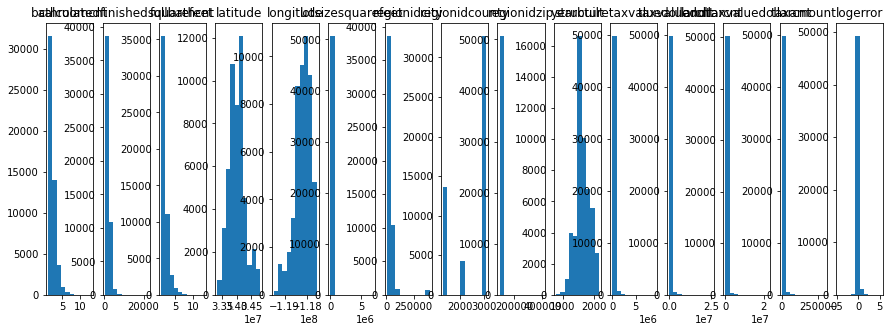

In [73]:
plt.figure(figsize=(15, 5))

for i, col in enumerate(cols,1):

    # i starts at 0, but plot nos should start at 1
    plot_number = i

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist()

    # Hide gridlines.
    plt.grid()
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

In [74]:
df.shape

(50676, 19)

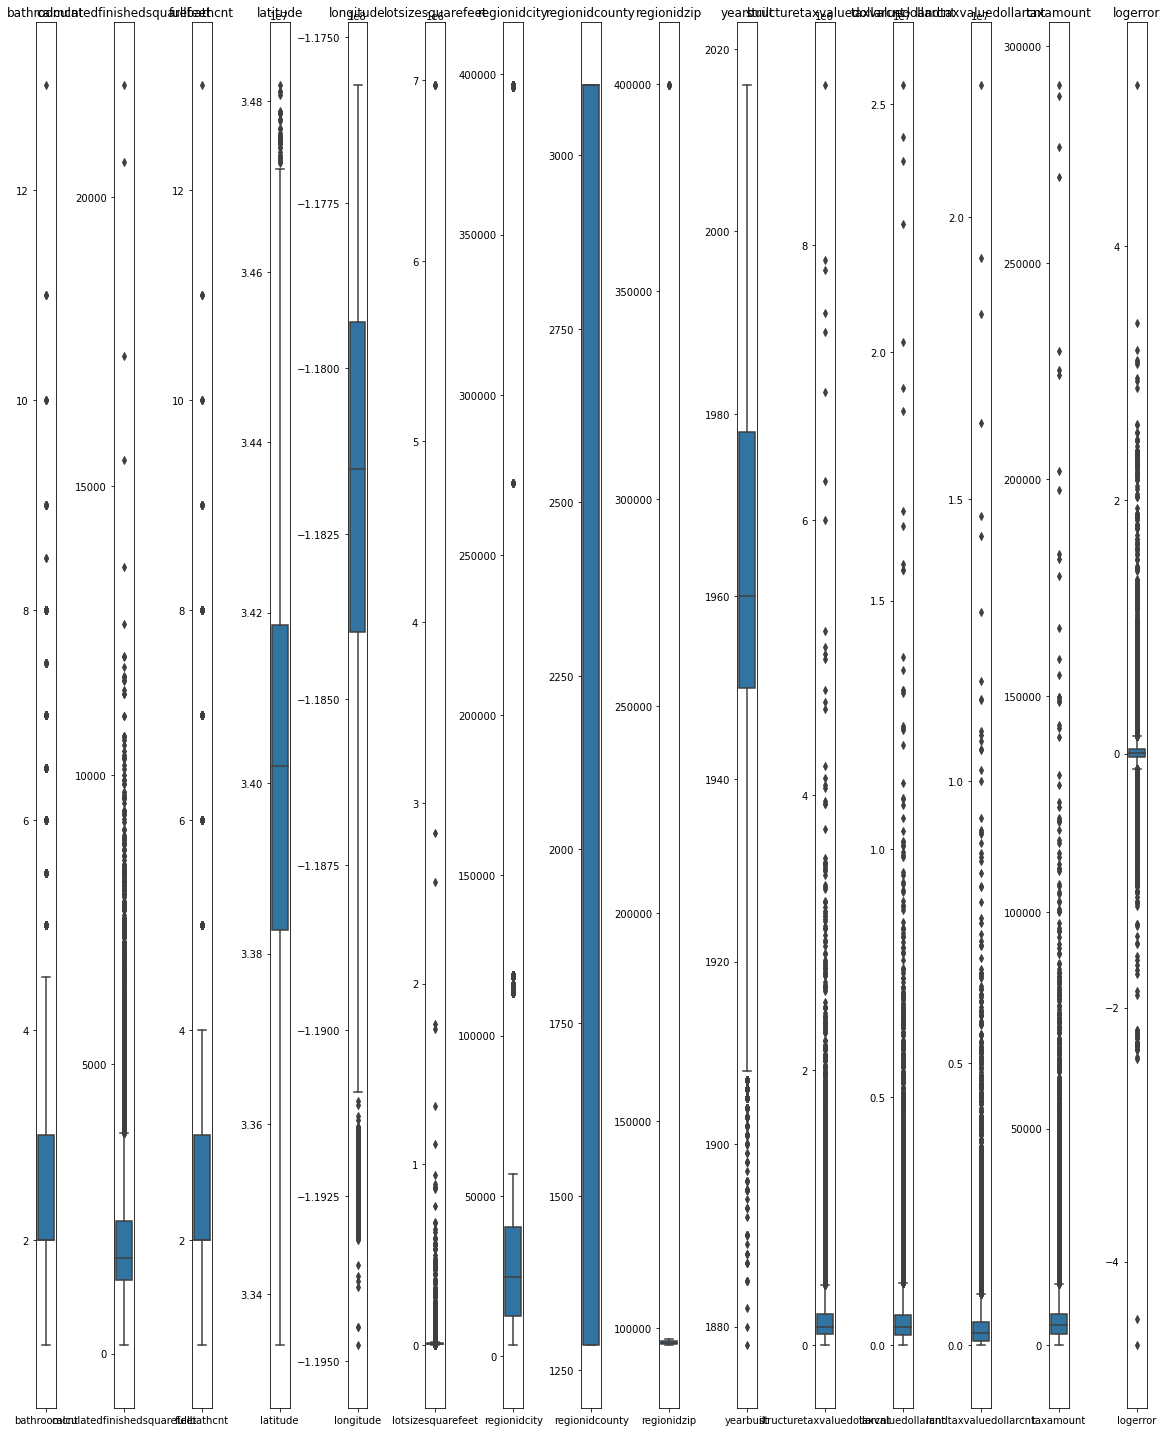

In [75]:
# List of columns
        
plt.figure(figsize=(16, 20))

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=df[[col]])

    # Hide gridlines.
    plt.grid(False)
    
    # sets proper spacing between plots
    plt.tight_layout()

plt.show()

In [76]:
df.shape

(50676, 19)

In [77]:
# remove outliers from each column in cols_list
for col in cols:

    q1, q3 = df[col].quantile([.25, .75])  # get quartiles

    iqr = q3 - q1   # calculate interquartile range

    upper_bound = q3 + 1.5 * iqr   # get upper bound
    lower_bound = q1 - 1.5 * iqr   # get lower bound

    # return dataframe without outliers

    df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]

In [78]:
df.shape

(31456, 19)

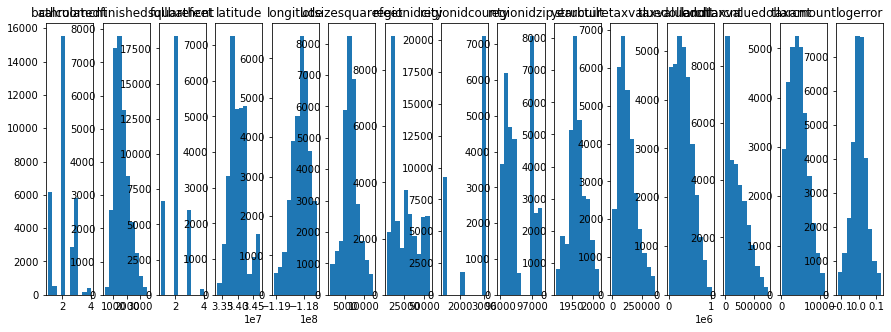

In [79]:
plt.figure(figsize=(15, 5))

for i, col in enumerate(cols,1):

    # i starts at 0, but plot nos should start at 1
    plot_number = i

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist()

    # Hide gridlines.
    plt.grid()
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

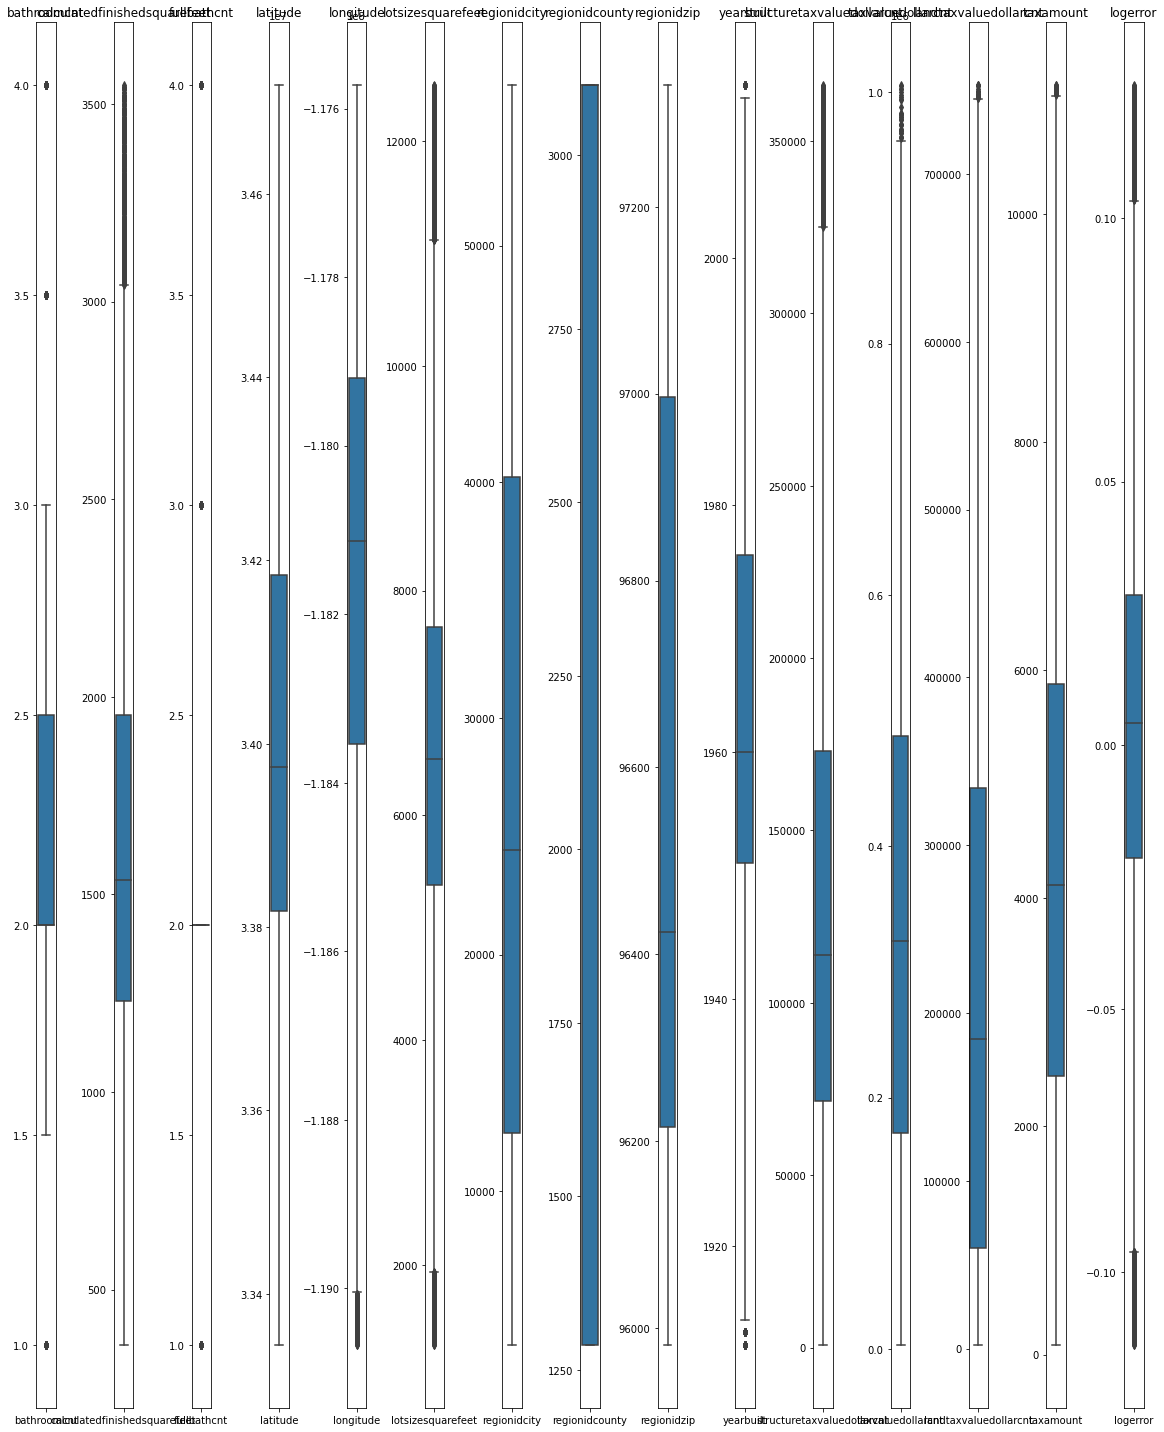

In [80]:
# List of columns
        
plt.figure(figsize=(16, 20))

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=df[[col]])

    # Hide gridlines.
    plt.grid(False)
    
    # sets proper spacing between plots
    plt.tight_layout()

plt.show()

## Rename for Readability

In [81]:
df.columns.to_list()

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'fips',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'propertycountylandusecode',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'logerror',
 'heatingorsystemdesc']

In [82]:
# rename for readability
df = df.rename(columns = {'bathroomcnt':'bathrooms',
 'bedroomcnt':'bedrooms',
 'calculatedfinishedsquarefeet':'house_area',
 'fullbathcnt':'full_baths',
 'lotsizesquarefeet':'lot_area',
 'propertycountylandusecode':'land_use_code',
 'regionidcity':'city_id',
 'regionidcounty':'county_id',
 'regionidzip':'zip_id',
 'yearbuilt':'year_built',
 'structuretaxvaluedollarcnt':'tax_value_house',
 'taxvaluedollarcnt':'tax_value_total',
 'landtaxvaluedollarcnt':'tax_value_land',
 'taxamount':'tax_amount',
 'heatingorsystemdesc':'heating_sys',
})

In [83]:
df.columns.to_list()

['bathrooms',
 'bedrooms',
 'house_area',
 'fips',
 'full_baths',
 'latitude',
 'longitude',
 'lot_area',
 'land_use_code',
 'city_id',
 'county_id',
 'zip_id',
 'year_built',
 'tax_value_house',
 'tax_value_total',
 'tax_value_land',
 'tax_amount',
 'logerror',
 'heating_sys']

## Add Columns: Age, Absolute LogError, County, HouseDolloarPerSqft, TaxRate, BedBath Ratio

In [84]:
df.shape

(31456, 19)

In [85]:
dft = df

In [86]:
# create column for age of house
df['age'] = 2017 - df.year_built
df.head()

bathrooms  bedrooms  house_area    fips  full_baths    latitude  \
37107        2.0       3.0      2107.0  6037.0         2.0  34222559.0   
48127        2.0       4.0      1882.0  6037.0         2.0  34220261.0   
15458        2.0       4.0      1882.0  6037.0         2.0  34222491.0   
12040        2.0       3.0      1477.0  6037.0         2.0  34221864.0   
13593        2.0       4.0      1918.0  6037.0         2.0  34220619.0   

         longitude  lot_area land_use_code  city_id  county_id   zip_id  \
37107 -118617387.0    9158.0          0101  12447.0     3101.0  96339.0   
48127 -118616409.0    9035.0          0101  12447.0     3101.0  96339.0   
15458 -118616854.0    9800.0          0100  12447.0     3101.0  96339.0   
12040 -118615739.0   11285.0          0101  12447.0     3101.0  96339.0   
13593 -118615253.0   11239.0          0101  12447.0     3101.0  96339.0   

       year_built  tax_value_house  tax_value_total  tax_value_land  \
37107      1972.0         249655.0         624139.0        374484.0   
48127      1972.0         253000.0         660000.0        407000.0   
15458      1972.0         257591.0         542923.0        285332.0   
12040      1960.0          57968.0          78031.0         20063.0   
13593      1960.0         167869.0         415459.0        247590.0   

       tax_amount  logerror heating_sys   age  
37107     7659.36 -0.007357     Central  45.0  
48127     8123.91  0.021066     Central  45.0  
15458     6673.24  0.077174     Central  45.0  
12040     1116.46 -0.041238     Central  57.0  
13593     5239.85 -0.009496     Central  57.0

In [87]:
# Create column for absolute value of logerror
df['logerror_abs'] = df.logerror.abs()
df.head()

bathrooms  bedrooms  house_area    fips  full_baths    latitude  \
37107        2.0       3.0      2107.0  6037.0         2.0  34222559.0   
48127        2.0       4.0      1882.0  6037.0         2.0  34220261.0   
15458        2.0       4.0      1882.0  6037.0         2.0  34222491.0   
12040        2.0       3.0      1477.0  6037.0         2.0  34221864.0   
13593        2.0       4.0      1918.0  6037.0         2.0  34220619.0   

         longitude  lot_area land_use_code  city_id  ...   zip_id  year_built  \
37107 -118617387.0    9158.0          0101  12447.0  ...  96339.0      1972.0   
48127 -118616409.0    9035.0          0101  12447.0  ...  96339.0      1972.0   
15458 -118616854.0    9800.0          0100  12447.0  ...  96339.0      1972.0   
12040 -118615739.0   11285.0          0101  12447.0  ...  96339.0      1960.0   
13593 -118615253.0   11239.0          0101  12447.0  ...  96339.0      1960.0   

       tax_value_house  tax_value_total  tax_value_land  tax_amount  logerror  \
37107         249655.0         624139.0        374484.0     7659.36 -0.007357   
48127         253000.0         660000.0        407000.0     8123.91  0.021066   
15458         257591.0         542923.0        285332.0     6673.24  0.077174   
12040          57968.0          78031.0         20063.0     1116.46 -0.041238   
13593         167869.0         415459.0        247590.0     5239.85 -0.009496   

       heating_sys   age  logerror_abs  
37107      Central  45.0      0.007357  
48127      Central  45.0      0.021066  
15458      Central  45.0      0.077174  
12040      Central  57.0      0.041238  
13593      Central  57.0      0.009496  

[5 rows x 21 columns]

In [88]:
# create columsn to match fips to county(LA, Orange County, Ventury County)
df['county'] = df.fips.map({6037:'LA',
            6059:'OC',
            6111:'Ventura'})
df.head()

bathrooms  bedrooms  house_area    fips  full_baths    latitude  \
37107        2.0       3.0      2107.0  6037.0         2.0  34222559.0   
48127        2.0       4.0      1882.0  6037.0         2.0  34220261.0   
15458        2.0       4.0      1882.0  6037.0         2.0  34222491.0   
12040        2.0       3.0      1477.0  6037.0         2.0  34221864.0   
13593        2.0       4.0      1918.0  6037.0         2.0  34220619.0   

         longitude  lot_area land_use_code  city_id  ...  year_built  \
37107 -118617387.0    9158.0          0101  12447.0  ...      1972.0   
48127 -118616409.0    9035.0          0101  12447.0  ...      1972.0   
15458 -118616854.0    9800.0          0100  12447.0  ...      1972.0   
12040 -118615739.0   11285.0          0101  12447.0  ...      1960.0   
13593 -118615253.0   11239.0          0101  12447.0  ...      1960.0   

       tax_value_house  tax_value_total  tax_value_land  tax_amount  logerror  \
37107         249655.0         624139.0        374484.0     7659.36 -0.007357   
48127         253000.0         660000.0        407000.0     8123.91  0.021066   
15458         257591.0         542923.0        285332.0     6673.24  0.077174   
12040          57968.0          78031.0         20063.0     1116.46 -0.041238   
13593         167869.0         415459.0        247590.0     5239.85 -0.009496   

       heating_sys   age logerror_abs  county  
37107      Central  45.0     0.007357      LA  
48127      Central  45.0     0.021066      LA  
15458      Central  45.0     0.077174      LA  
12040      Central  57.0     0.041238      LA  
13593      Central  57.0     0.009496      LA  

[5 rows x 22 columns]

In [89]:
# create column for Dollar per square foot
df['house_dollar_sqft'] = df.tax_value_total / df.house_area
df.head()

bathrooms  bedrooms  house_area    fips  full_baths    latitude  \
37107        2.0       3.0      2107.0  6037.0         2.0  34222559.0   
48127        2.0       4.0      1882.0  6037.0         2.0  34220261.0   
15458        2.0       4.0      1882.0  6037.0         2.0  34222491.0   
12040        2.0       3.0      1477.0  6037.0         2.0  34221864.0   
13593        2.0       4.0      1918.0  6037.0         2.0  34220619.0   

         longitude  lot_area land_use_code  city_id  ...  tax_value_house  \
37107 -118617387.0    9158.0          0101  12447.0  ...         249655.0   
48127 -118616409.0    9035.0          0101  12447.0  ...         253000.0   
15458 -118616854.0    9800.0          0100  12447.0  ...         257591.0   
12040 -118615739.0   11285.0          0101  12447.0  ...          57968.0   
13593 -118615253.0   11239.0          0101  12447.0  ...         167869.0   

       tax_value_total  tax_value_land  tax_amount  logerror  heating_sys  \
37107         624139.0        374484.0     7659.36 -0.007357      Central   
48127         660000.0        407000.0     8123.91  0.021066      Central   
15458         542923.0        285332.0     6673.24  0.077174      Central   
12040          78031.0         20063.0     1116.46 -0.041238      Central   
13593         415459.0        247590.0     5239.85 -0.009496      Central   

        age  logerror_abs county  house_dollar_sqft  
37107  45.0      0.007357     LA         296.221642  
48127  45.0      0.021066     LA         350.690755  
15458  45.0      0.077174     LA         288.481934  
12040  57.0      0.041238     LA          52.830738  
13593  57.0      0.009496     LA         216.610532  

[5 rows x 23 columns]

In [90]:
# Create column for land dollar per sqft
df['land_dollar_sqft'] = df.tax_value_land / df.lot_area
df.head()

bathrooms  bedrooms  house_area    fips  full_baths    latitude  \
37107        2.0       3.0      2107.0  6037.0         2.0  34222559.0   
48127        2.0       4.0      1882.0  6037.0         2.0  34220261.0   
15458        2.0       4.0      1882.0  6037.0         2.0  34222491.0   
12040        2.0       3.0      1477.0  6037.0         2.0  34221864.0   
13593        2.0       4.0      1918.0  6037.0         2.0  34220619.0   

         longitude  lot_area land_use_code  city_id  ...  tax_value_total  \
37107 -118617387.0    9158.0          0101  12447.0  ...         624139.0   
48127 -118616409.0    9035.0          0101  12447.0  ...         660000.0   
15458 -118616854.0    9800.0          0100  12447.0  ...         542923.0   
12040 -118615739.0   11285.0          0101  12447.0  ...          78031.0   
13593 -118615253.0   11239.0          0101  12447.0  ...         415459.0   

       tax_value_land  tax_amount  logerror  heating_sys   age  logerror_abs  \
37107        374484.0     7659.36 -0.007357      Central  45.0      0.007357   
48127        407000.0     8123.91  0.021066      Central  45.0      0.021066   
15458        285332.0     6673.24  0.077174      Central  45.0      0.077174   
12040         20063.0     1116.46 -0.041238      Central  57.0      0.041238   
13593        247590.0     5239.85 -0.009496      Central  57.0      0.009496   

       county house_dollar_sqft  land_dollar_sqft  
37107      LA        296.221642         40.891461  
48127      LA        350.690755         45.047039  
15458      LA        288.481934         29.115510  
12040      LA         52.830738          1.777847  
13593      LA        216.610532         22.029540  

[5 rows x 24 columns]

In [91]:
# create column for tax rate
df['tax_rate'] = df.tax_value_house / df.tax_amount
df.head()

bathrooms  bedrooms  house_area    fips  full_baths    latitude  \
37107        2.0       3.0      2107.0  6037.0         2.0  34222559.0   
48127        2.0       4.0      1882.0  6037.0         2.0  34220261.0   
15458        2.0       4.0      1882.0  6037.0         2.0  34222491.0   
12040        2.0       3.0      1477.0  6037.0         2.0  34221864.0   
13593        2.0       4.0      1918.0  6037.0         2.0  34220619.0   

         longitude  lot_area land_use_code  city_id  ...  tax_value_land  \
37107 -118617387.0    9158.0          0101  12447.0  ...        374484.0   
48127 -118616409.0    9035.0          0101  12447.0  ...        407000.0   
15458 -118616854.0    9800.0          0100  12447.0  ...        285332.0   
12040 -118615739.0   11285.0          0101  12447.0  ...         20063.0   
13593 -118615253.0   11239.0          0101  12447.0  ...        247590.0   

       tax_amount  logerror  heating_sys   age  logerror_abs  county  \
37107     7659.36 -0.007357      Central  45.0      0.007357      LA   
48127     8123.91  0.021066      Central  45.0      0.021066      LA   
15458     6673.24  0.077174      Central  45.0      0.077174      LA   
12040     1116.46 -0.041238      Central  57.0      0.041238      LA   
13593     5239.85 -0.009496      Central  57.0      0.009496      LA   

       house_dollar_sqft land_dollar_sqft   tax_rate  
37107         296.221642        40.891461  32.594760  
48127         350.690755        45.047039  31.142639  
15458         288.481934        29.115510  38.600590  
12040          52.830738         1.777847  51.921251  
13593         216.610532        22.029540  32.036986  

[5 rows x 25 columns]

In [92]:
# create column for bed bath ratio
df['bed_bath_ratio'] = df.bedrooms / df.bathrooms
df.head()

bathrooms  bedrooms  house_area    fips  full_baths    latitude  \
37107        2.0       3.0      2107.0  6037.0         2.0  34222559.0   
48127        2.0       4.0      1882.0  6037.0         2.0  34220261.0   
15458        2.0       4.0      1882.0  6037.0         2.0  34222491.0   
12040        2.0       3.0      1477.0  6037.0         2.0  34221864.0   
13593        2.0       4.0      1918.0  6037.0         2.0  34220619.0   

         longitude  lot_area land_use_code  city_id  ...  tax_amount  \
37107 -118617387.0    9158.0          0101  12447.0  ...     7659.36   
48127 -118616409.0    9035.0          0101  12447.0  ...     8123.91   
15458 -118616854.0    9800.0          0100  12447.0  ...     6673.24   
12040 -118615739.0   11285.0          0101  12447.0  ...     1116.46   
13593 -118615253.0   11239.0          0101  12447.0  ...     5239.85   

       logerror  heating_sys   age  logerror_abs  county  house_dollar_sqft  \
37107 -0.007357      Central  45.0      0.007357      LA         296.221642   
48127  0.021066      Central  45.0      0.021066      LA         350.690755   
15458  0.077174      Central  45.0      0.077174      LA         288.481934   
12040 -0.041238      Central  57.0      0.041238      LA          52.830738   
13593 -0.009496      Central  57.0      0.009496      LA         216.610532   

       land_dollar_sqft   tax_rate  bed_bath_ratio  
37107         40.891461  32.594760             1.5  
48127         45.047039  31.142639             2.0  
15458         29.115510  38.600590             2.0  
12040          1.777847  51.921251             1.5  
13593         22.029540  32.036986             2.0  

[5 rows x 26 columns]

In [93]:
df.shape

(31456, 26)

In [94]:
df.columns.to_list()

['bathrooms',
 'bedrooms',
 'house_area',
 'fips',
 'full_baths',
 'latitude',
 'longitude',
 'lot_area',
 'land_use_code',
 'city_id',
 'county_id',
 'zip_id',
 'year_built',
 'tax_value_house',
 'tax_value_total',
 'tax_value_land',
 'tax_amount',
 'logerror',
 'heating_sys',
 'age',
 'logerror_abs',
 'county',
 'house_dollar_sqft',
 'land_dollar_sqft',
 'tax_rate',
 'bed_bath_ratio']

In [95]:
df = dft

In [96]:
def fix_cols(df):

    # rename for readability
    df = df.rename(columns = {'bathroomcnt':'bathrooms',
     'bedroomcnt':'bedrooms',
     'calculatedfinishedsquarefeet':'house_area',
     'fullbathcnt':'full_baths',
     'lotsizesquarefeet':'lot_area',
     'propertycountylandusecode':'land_use_code',
     'regionidcity':'city_id',
     'regionidcounty':'county_id',
     'regionidzip':'zip_id',
     'yearbuilt':'year_built',
     'structuretaxvaluedollarcnt':'tax_value_house',
     'taxvaluedollarcnt':'tax_value_total',
     'landtaxvaluedollarcnt':'tax_value_land',
     'taxamount':'tax_amount',
     'heatingorsystemdesc':'heating_sys',
    })



    # create column for age of house
    df['age'] = 2017 - df.year_built


    # Create column for absolute value of logerror
    df['logerror_abs'] = df.logerror.abs()


    # create columsn to match fips to county(LA, Orange County, Ventury County)
    df['county'] = df.fips.map({6037:'LA',
                6059:'OC',
                6111:'Ventura'})


    # create column for Dollar per square foot
    df['house_dollar_sqft'] = df.tax_value_total / df.house_area


    # Create column for land dollar per sqft
    df['land_dollar_sqft'] = df.tax_value_land / df.lot_area


    # create column for tax rate
    df['tax_rate'] = df.tax_value_house / df.tax_amount


    # create column for bed bath ratio
    df['bed_bath_ratio'] = df.bedrooms / df.bathrooms
    
    return df

In [97]:
df = fix_cols(df)
df.shape

(31456, 26)

In [98]:
df.columns

Index(['bathrooms', 'bedrooms', 'house_area', 'fips', 'full_baths', 'latitude',
       'longitude', 'lot_area', 'land_use_code', 'city_id', 'county_id',
       'zip_id', 'year_built', 'tax_value_house', 'tax_value_total',
       'tax_value_land', 'tax_amount', 'logerror', 'heating_sys', 'age',
       'logerror_abs', 'county', 'house_dollar_sqft', 'land_dollar_sqft',
       'tax_rate', 'bed_bath_ratio'],
      dtype='object')

# <font color = 'red'>Split

In [99]:
dft = df

In [100]:
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
train.shape, validate.shape, test.shape

((17614, 26), (7550, 26), (6292, 26))

In [101]:
df = dft

In [102]:
def split(df):
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    return train, validate, test

In [103]:
train, validate, test = split(df)
train.shape, validate.shape, test.shape

((17614, 26), (7550, 26), (6292, 26))

# <font color = 'red'> Explore Unscaled Data

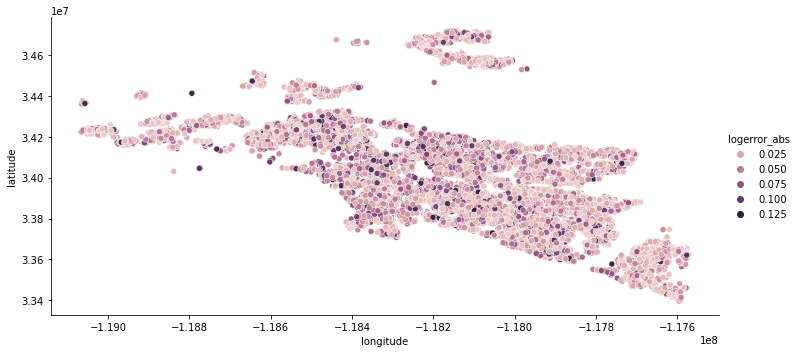

In [104]:
# show log eror for longitude vs latitude
sns.relplot(data=train, x='longitude', y='latitude', hue='logerror_abs', kind='scatter', height=5, aspect=2)

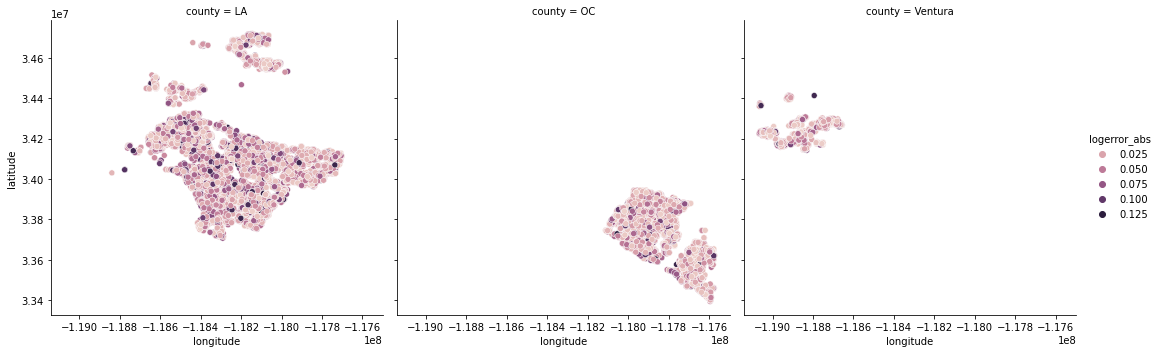

In [105]:
# show log eror for longitude vs latitude by county
sns.relplot(data=train, x='longitude', y='latitude', hue='logerror_abs', col='county', kind='scatter')

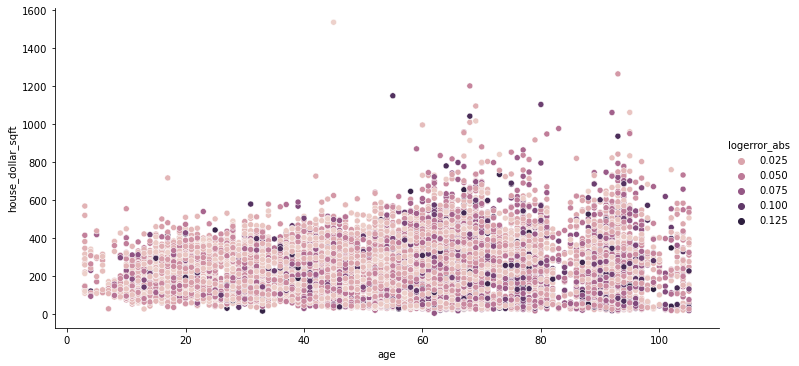

In [106]:
# show log eror for age vs house dollar per sqft
sns.relplot(data=train, x='age', y='house_dollar_sqft', hue='logerror_abs', kind='scatter', height=5, aspect=2)

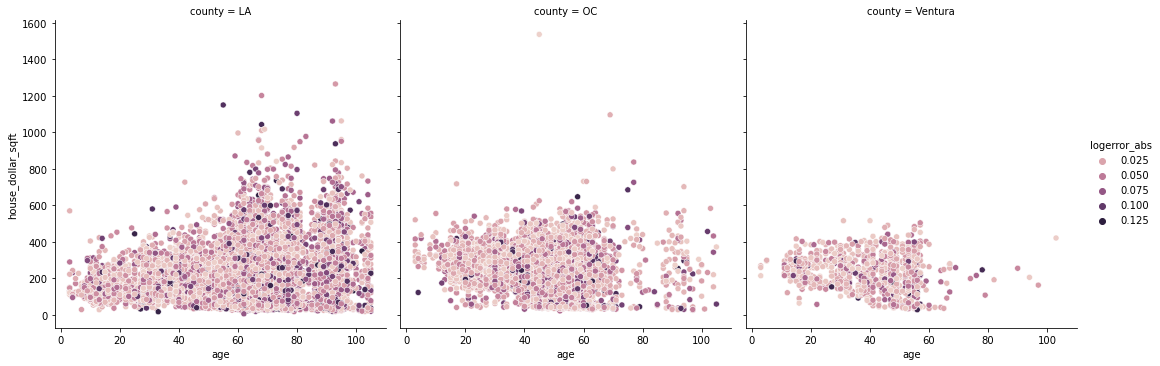

In [107]:
# show log eror for age vs house dollar per sqft by county
sns.relplot(data=train, x='age', y='house_dollar_sqft', hue='logerror_abs', col='county', kind='scatter')

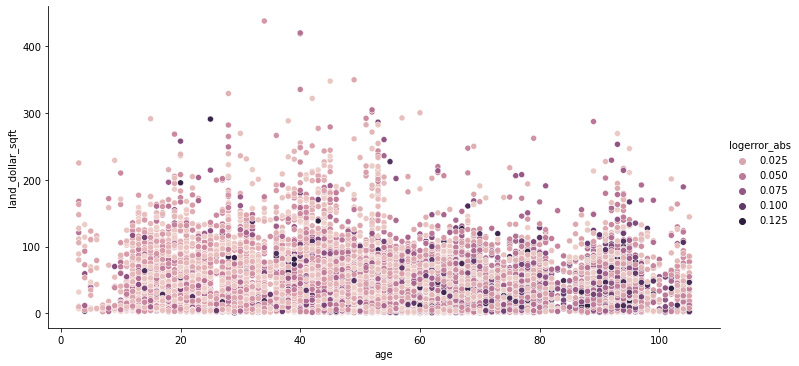

In [108]:
# show log error for age vs land dollar per sqft
sns.relplot(data=train, x='age', y='land_dollar_sqft', hue='logerror_abs', kind='scatter', height=5, aspect=2)

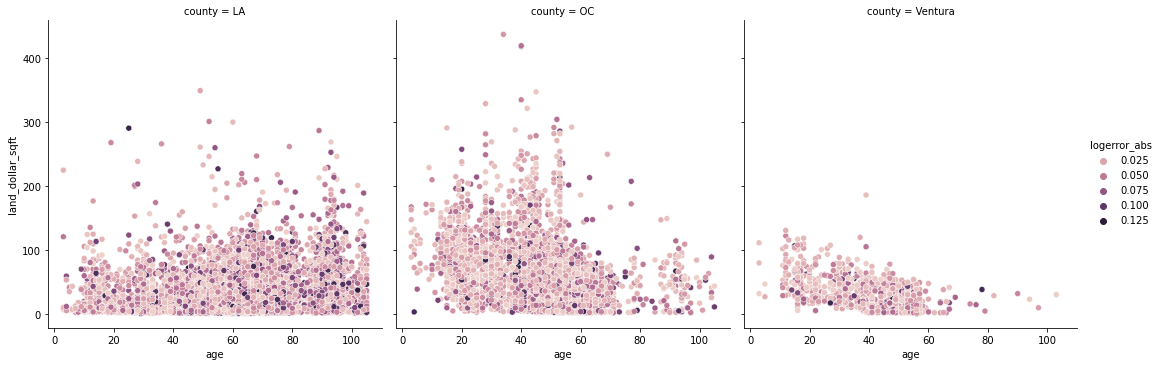

In [109]:
# show log error for age vs land dollar per sqft by county
sns.relplot(data=train, x='age', y='land_dollar_sqft', hue='logerror_abs', col='county', kind='scatter')

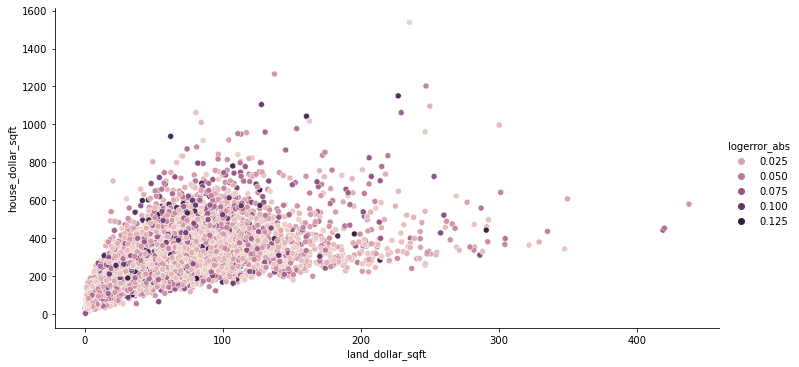

In [110]:
# show log error for house dollar per sqft vs land dollar per sqft
sns.relplot(data=train, x='land_dollar_sqft', y='house_dollar_sqft', hue='logerror_abs', kind='scatter', height=5, aspect=2)

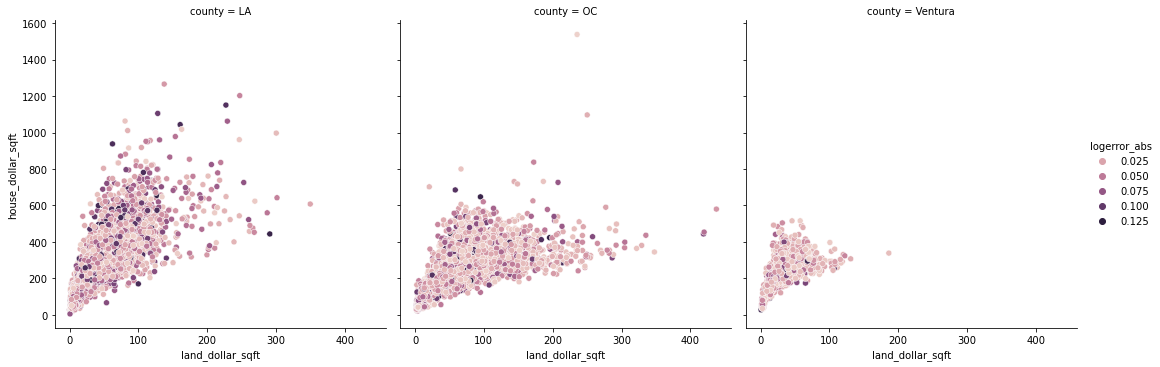

In [111]:
# show log error for house dollar per sqft vs land dollar per sqft by county
sns.relplot(data=train, x='land_dollar_sqft', y='house_dollar_sqft', hue='logerror_abs', col='county', kind='scatter')

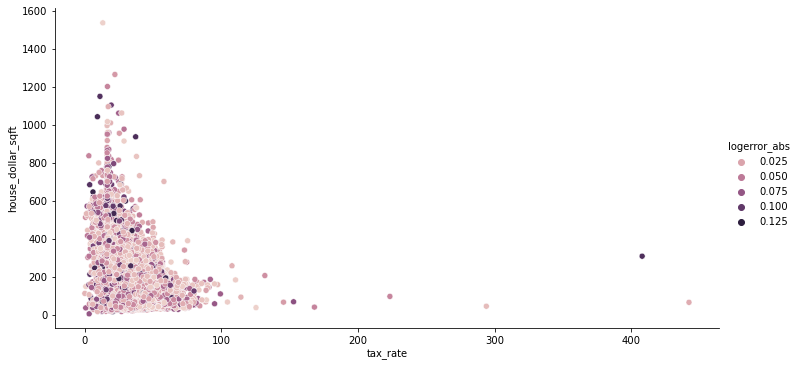

In [112]:
# show log error for tax rate vs land dollar per sqft
sns.relplot(data=train, x='tax_rate', y='house_dollar_sqft', hue='logerror_abs', kind='scatter', height=5, aspect=2)

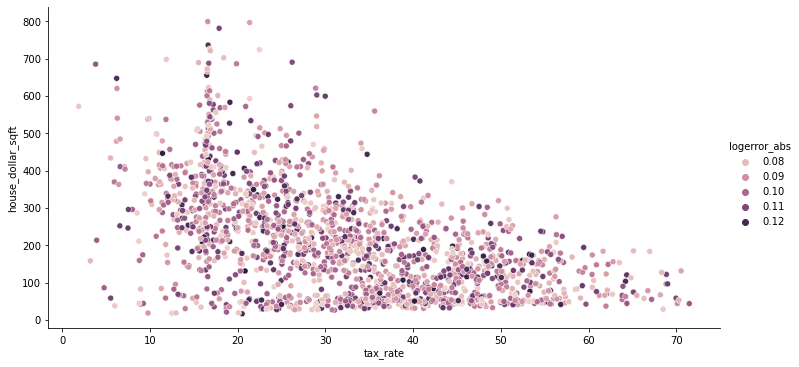

In [113]:
# show log error for tax rate vs land dollar per sqft
sns.relplot(data=train[(train.logerror_abs >= .075) & (train.house_dollar_sqft < 800) & (train.tax_rate < 75)],
            x='tax_rate', y='house_dollar_sqft', hue='logerror_abs', kind='scatter', height=5, aspect=2)

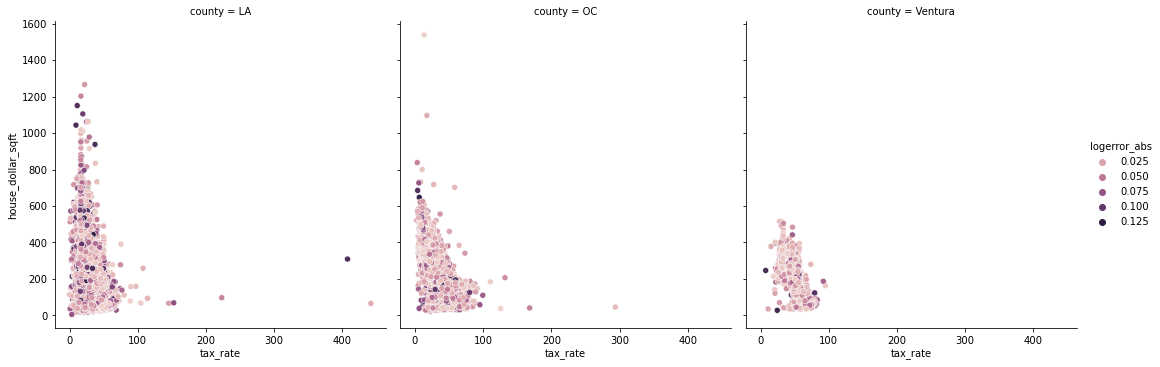

In [114]:
# show log error for tax rate vs land dollar per sqft by county
sns.relplot(data=train, x='tax_rate', y='house_dollar_sqft', hue='logerror_abs', col='county', kind='scatter')

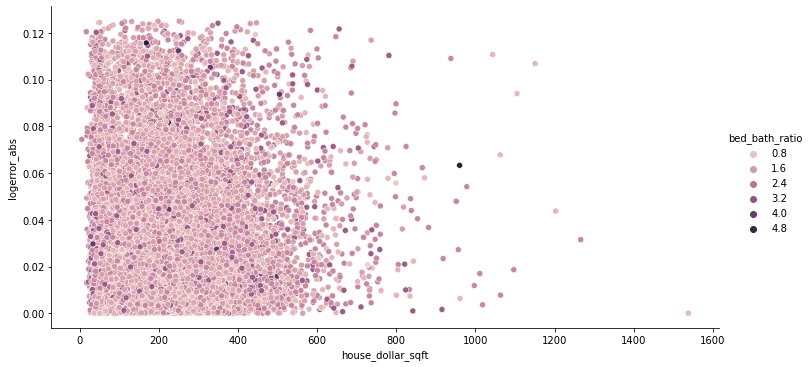

In [115]:
# show log error for house dollar per sqft vs logerror
sns.relplot(data=train, x='house_dollar_sqft', y='logerror_abs', hue='bed_bath_ratio', kind='scatter', height=5, aspect=2)

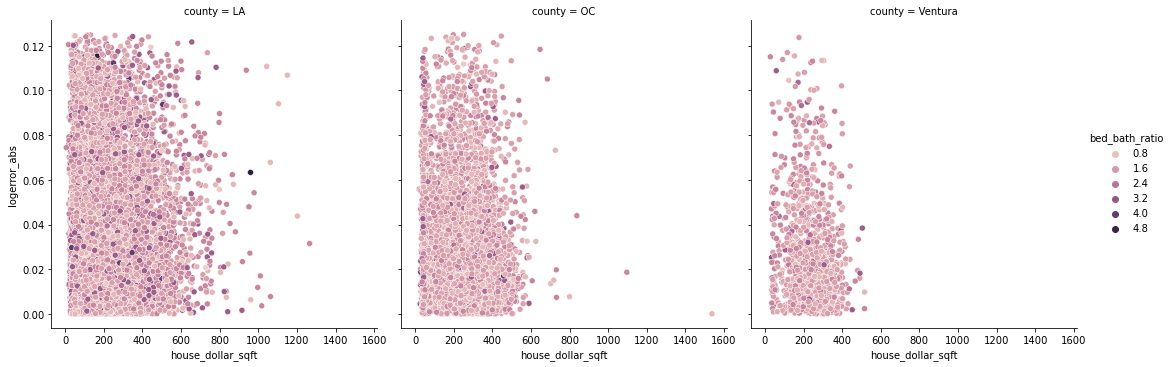

In [116]:
# show log error for house dollar per sqft vs logerror by county
sns.relplot(data=train, x='house_dollar_sqft', y='logerror_abs', hue='bed_bath_ratio', col='county',kind='scatter')

### Takeaways:
- cluster with long and lat, most in LA
- cluster with age and house dollar, more with LA and OC
- cluster with age and land dollar, or with LA
- strong cluster with land dollar and house dollar, mostly in LA

### Go Forward with Clustering Combos:
- age
- house dollar per sqft
- land dollar per sqft
- longitude and lattitude

# <font color = 'red'> Scale Data

In [117]:
# select columns to cluster and explore
cols = ['house_area', 'lot_area', 'tax_value_house', 'tax_value_total',
       'tax_value_land', 'age', 'longitude', 'latitude',
       'logerror_abs','house_dollar_sqft', 'land_dollar_sqft',
       'tax_rate', 'bed_bath_ratio', 'fips']

In [118]:
# Columns used for further exploration and clustering
train_cols = train[cols]
validate_cols = validate[cols]
test_cols = test[cols]
train_cols.head()

house_area  lot_area  tax_value_house  tax_value_total  tax_value_land  \
7245       1214.0    4692.0         134574.0         244679.0        110105.0   
20215      1398.0    6667.0          80534.0         205321.0        124787.0   
47536       864.0   11266.0          25000.0         375000.0        350000.0   
6815       1006.0    5460.0          45646.0         228268.0        182622.0   
31349      1802.0    9570.0         194600.0         550000.0        355400.0   

        age    longitude    latitude  logerror_abs  house_dollar_sqft  \
7245   77.0 -118219071.0  33941146.0      0.021805         201.547776   
20215  59.0 -117850438.0  33806613.0      0.006413         146.867668   
47536  89.0 -118159711.0  34164721.0      0.081616         434.027778   
6815   69.0 -118321763.0  33873120.0      0.048739         226.906561   
31349  40.0 -117785574.0  34114707.0      0.001546         305.216426   

       land_dollar_sqft   tax_rate  bed_bath_ratio    fips  
7245          23.466539  40.688882             1.5  6037.0  
20215         18.717114  33.621114             1.5  6059.0  
47536         31.066927   5.495448             2.0  6037.0  
6815          33.447253  16.730565             3.0  6037.0  
31349         37.136886  30.048996             1.5  6037.0

In [119]:
# Make the scaler with MinMax
scaler = MinMaxScaler()

# Fit the scalter to X_train
scaler.fit(train_cols)

# Transform train, validate, test to scaled version
train_scaled = scaler.transform(train_cols)
validate_scaled = scaler.transform(validate_cols)
test_scaled = scaler.transform(test_cols)

In [120]:
# Make the scaled arrays into dataframes
train_scaled = pd.DataFrame(train_scaled, columns=train_cols.columns, index=train_cols.index)
validate_scaled = pd.DataFrame(validate_scaled, columns=validate_cols.columns, index=validate_cols.index)
test_scaled = pd.DataFrame(test_scaled, columns=test_cols.columns, index=test_cols.index)
train_scaled

house_area  lot_area  tax_value_house  tax_value_total  tax_value_land  \
7245     0.268385  0.303490         0.365809         0.240864        0.143707   
20215    0.326210  0.479782         0.217809         0.201597        0.163270   
47536    0.158391  0.890297         0.065718         0.370881        0.463346   
6815     0.203017  0.372043         0.122261         0.224491        0.240330   
31349    0.453174  0.738909         0.530202         0.545474        0.470541   
...           ...       ...              ...              ...             ...   
49682    0.140792  0.359547         0.236687         0.204827        0.158398   
41462    0.413262  0.170401         0.418080         0.350643        0.264889   
14465    0.452231  0.602874         0.426427         0.698583        0.725507   
50598    0.238215  0.397215         0.219428         0.401438        0.429374   
41812    0.338152  0.536553         0.457353         0.206265        0.052963   

            age  longitude  latitude  logerror_abs  house_dollar_sqft  \
7245   0.725490   0.567711  0.412765      0.174335           0.127935   
20215  0.549020   0.814525  0.311107      0.051261           0.092248   
47536  0.843137   0.607455  0.581707      0.652562           0.279664   
6815   0.647059   0.498955  0.361362      0.389683           0.144486   
31349  0.362745   0.857954  0.543914      0.012349           0.195595   
...         ...        ...       ...           ...                ...   
49682  0.705882   0.603597  0.361031      0.882619           0.164855   
41462  0.254902   0.245280  0.562683      0.108258           0.134607   
14465  0.529412   0.424006  0.565200      0.804711           0.251602   
50598  0.696078   0.627544  0.356251      0.297574           0.233188   
41812  0.245098   0.675349  0.884171      0.031566           0.091838   

       land_dollar_sqft  tax_rate  bed_bath_ratio      fips  
7245           0.053175  0.091551        0.222222  0.000000  
20215          0.042319  0.075558        0.222222  0.297297  
47536          0.070548  0.011915        0.333333  0.000000  
6815           0.075988  0.037338        0.555556  0.000000  
31349          0.084422  0.067475        0.222222  0.000000  
...                 ...       ...             ...       ...  
49682          0.051581  0.075985        0.333333  0.000000  
41462          0.143102  0.081762        0.037037  0.000000  
14465          0.154860  0.040097        0.111111  0.000000  
50598          0.128712  0.037659        0.555556  0.000000  
41812          0.012683  0.108744        0.333333  0.000000  

[17614 rows x 14 columns]

In [121]:
def scale_cols(train, validate, test):
    
    # Scaler
    from sklearn.preprocessing import MinMaxScaler
    
    # select columns to cluster and explore
    cols = ['house_area', 'lot_area', 'tax_value_house', 'tax_value_total',
           'tax_value_land', 'age', 'longitude','latitude',
           'logerror_abs','house_dollar_sqft', 'land_dollar_sqft',
           'tax_rate', 'bed_bath_ratio', 'fips']

    # Columns used for further exploration and clustering
    train_cols = train[cols]
    validate_cols = validate[cols]
    test_cols = test[cols]

    # Make the scaler with MinMax
    scaler = MinMaxScaler()

    # Fit the scalter to X_train
    scaler.fit(train_cols)

    # Transform train, validate, test to scaled version
    train_scaled = scaler.transform(train_cols)
    validate_scaled = scaler.transform(validate_cols)
    test_scaled = scaler.transform(test_cols)

    # Make the scaled arrays into dataframes
    train_scaled = pd.DataFrame(train_scaled, columns=train_cols.columns, index=train_cols.index)
    validate_scaled = pd.DataFrame(validate_scaled, columns=validate_cols.columns, index=validate_cols.index)
    test_scaled = pd.DataFrame(test_scaled, columns=test_cols.columns, index=test_cols.index)
    
    return train_scaled, validate_scaled, test_scaled

In [122]:
train_scaled, validate_scaled, test_scaled = scale_cols(train, validate, test)
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((17614, 14), (7550, 14), (6292, 14))

## <font color = 'red'>Explore Scaled Data

### Viz Age for Land Dollar per Sqft vs House Dollar per Sqft by FIP

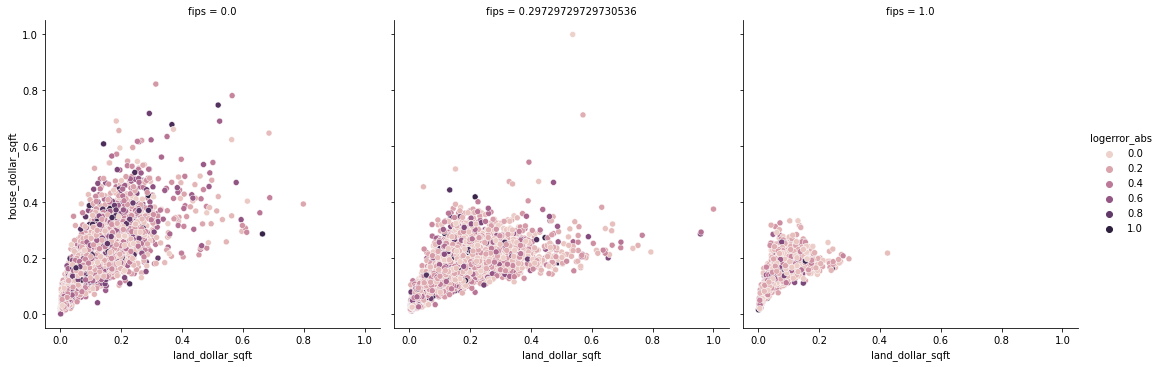

In [123]:
# show logerror for land dollar vs house dollar by county
sns.relplot(data=train_scaled, x='land_dollar_sqft', y='house_dollar_sqft', hue='logerror_abs', col='fips', kind='scatter')

### Takeaways:
- cluster in LA

### Viz Log Error for Age for House Dollar Sqft per Fip

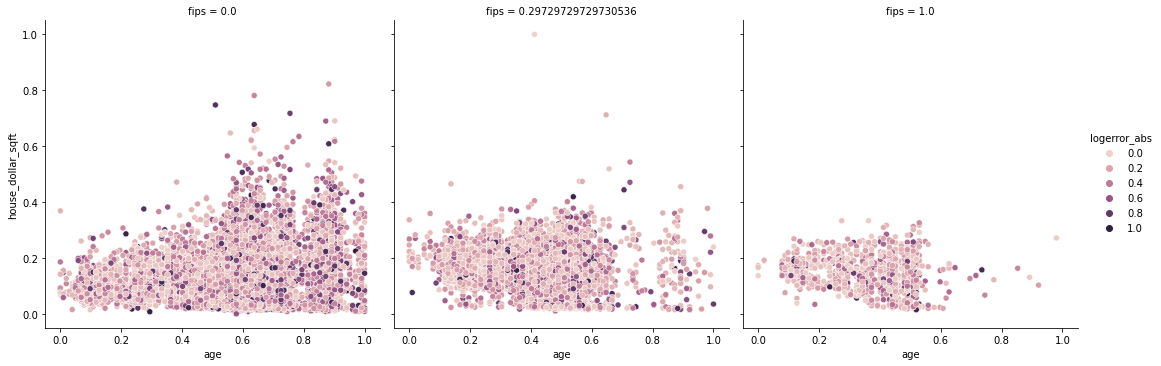

In [124]:
# Show logerror for age by house dollar per sqft by county
sns.relplot(data=train_scaled, x='age', y='house_dollar_sqft', hue='logerror_abs', col='fips',kind='scatter')

### Takeaways:
- Logerror clusters with older houses

### Viz Bed Bath Ratio for  Age for House Dollar Sqft per Fip

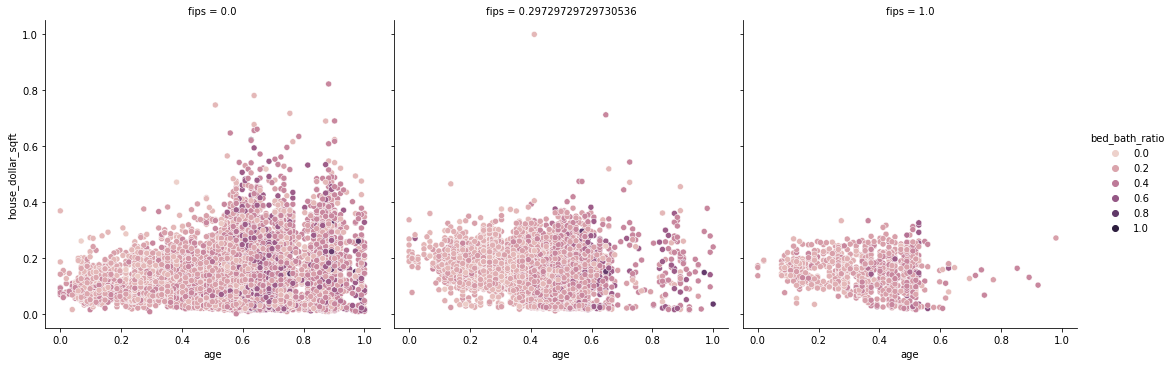

In [125]:
sns.relplot(data=train_scaled, x='age', y='house_dollar_sqft', hue='bed_bath_ratio', col='fips', kind='scatter')

### Takeaways:
- bed bath ratio clusters with older homes

### Viz Tax Rate for  Age vs House Dollar Sqft per Fip

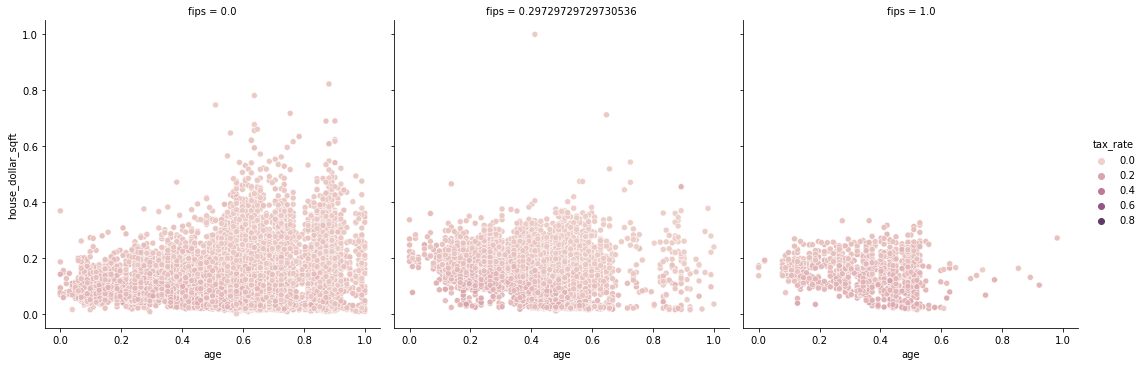

In [126]:
sns.relplot(data=train_scaled, x='age', y='house_dollar_sqft', hue='tax_rate', col='fips', kind='scatter')

### Scaled Exploration Takeaways:
- Tax Rate clusters with older homes
- Bed bath ratio clusters with older homes
- Logerror clusters with older houses
- Logerror clusters with house dollar and dollar



## Going Forward with 
- Age
- House_Dollar_Sqft
- Land_Dollar_Sqft
- lattitude and longitude
- Best K = 3 (Age, Tax Rate, Bed_Bath_Ratio)

# <font color = 'red'> Clustering Combo 1 (House Dollar Per Sqft and Age)

In [127]:
# Filter columns from train scaled
cols = ['house_dollar_sqft', 'age']
train_scaled_X = train_scaled[cols]
train_scaled_X.head()

house_dollar_sqft       age
7245            0.127935  0.725490
20215           0.092248  0.549020
47536           0.279664  0.843137
6815            0.144486  0.647059
31349           0.195595  0.362745

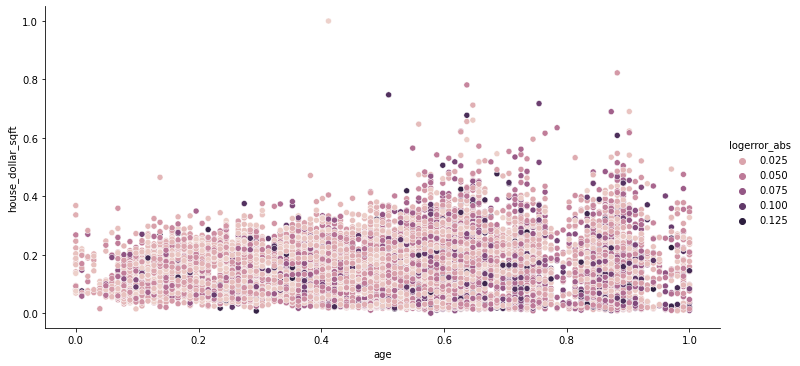

In [128]:
sns.relplot(data=train_scaled, x='age', y='house_dollar_sqft', hue= train.logerror_abs, kind='scatter', height=5, aspect=2)

## <font color = 'red'>Elbow Method

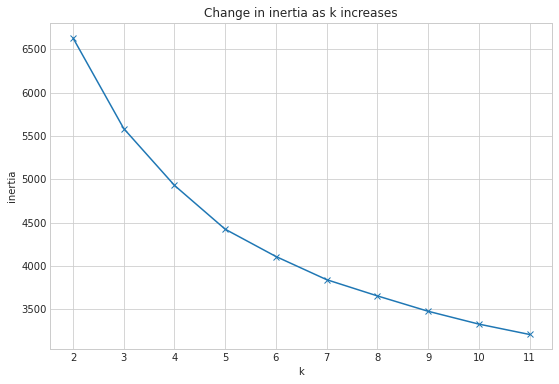

In [129]:
# Use elbow method to see if inertia values support visual exploration
# plot inertia vs k

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k, random_state=123).fit(train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

### Takeaway:
- K vallues between 3 - 5
- Forward with k = 3

In [130]:
# Move forward with k=3
kmeans = KMeans(n_clusters = 6, random_state=123)
kmeans.fit(train_scaled_X)

# And assign the cluster number to a column on the dataframe
train["cluster"] = kmeans.predict(train_scaled_X)
train.head()

bathrooms  bedrooms  house_area    fips  full_baths    latitude  \
7245         2.0       3.0      1214.0  6037.0         2.0  33941146.0   
20215        2.0       3.0      1398.0  6059.0         2.0  33806613.0   
47536        1.0       2.0       864.0  6037.0         1.0  34164721.0   
6815         1.0       3.0      1006.0  6037.0         1.0  33873120.0   
31349        2.0       3.0      1802.0  6037.0         2.0  34114707.0   

         longitude  lot_area land_use_code  city_id  ...  logerror  \
7245  -118219071.0    4692.0          0100  47762.0  ... -0.021805   
20215 -117850438.0    6667.0           122  33252.0  ... -0.006413   
47536 -118159711.0   11266.0          0100  47019.0  ... -0.081616   
6815  -118321763.0    5460.0          0100  54722.0  ... -0.048739   
31349 -117785574.0    9570.0          0100  39308.0  ...  0.001546   

       heating_sys   age  logerror_abs  county  house_dollar_sqft  \
7245    Floor/Wall  77.0      0.021805      LA         201.547776   
20215         None  59.0      0.006413      OC         146.867668   
47536   Floor/Wall  89.0      0.081616      LA         434.027778   
6815    Floor/Wall  69.0      0.048739      LA         226.906561   
31349      Central  40.0      0.001546      LA         305.216426   

       land_dollar_sqft   tax_rate bed_bath_ratio  cluster  
7245          23.466539  40.688882            1.5        5  
20215         18.717114  33.621114            1.5        2  
47536         31.066927   5.495448            2.0        0  
6815          33.447253  16.730565            3.0        3  
31349         37.136886  30.048996            1.5        1  

[5 rows x 27 columns]

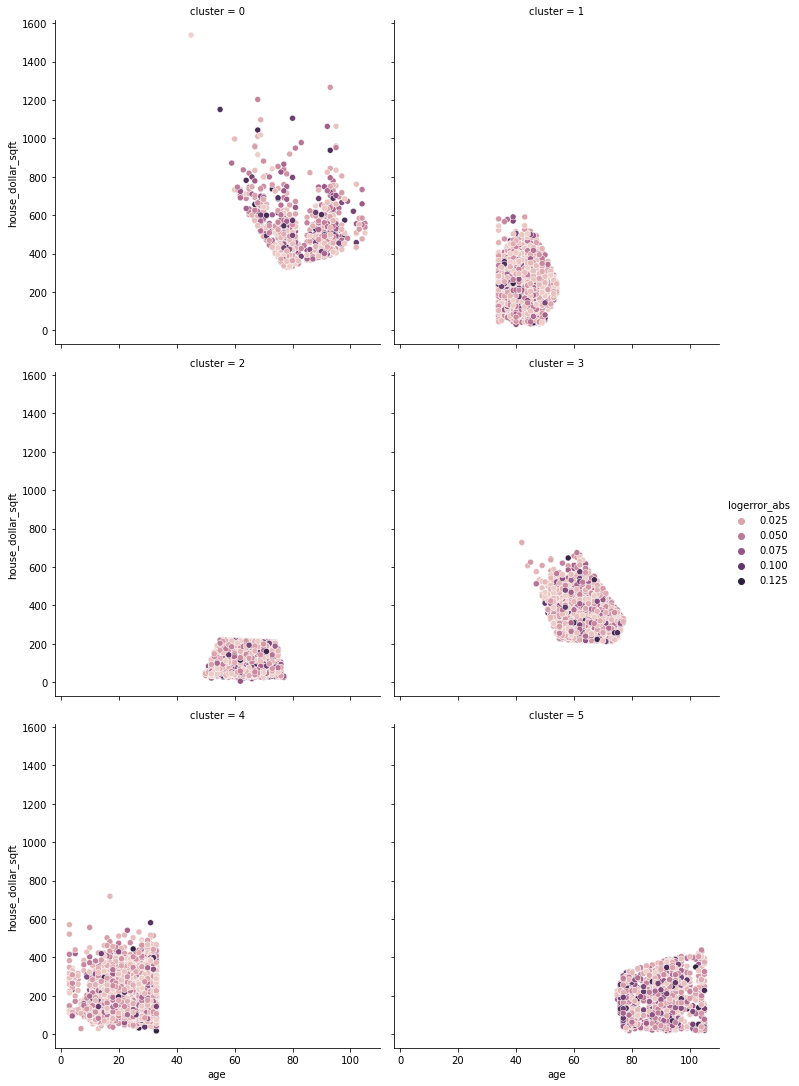

In [131]:
# show house dollar per sqft for age vs log error by cluster
sns.relplot(data=train, x="age", y="house_dollar_sqft", col="cluster", hue='logerror_abs', col_wrap=2)

### Takeaways:
- cluster 2 shows highest log errors

### Check Significant Difference

In [202]:
# check mean of logerror for each cluster
train.groupby(by='cluster').logerror_abs.mean()

cluster
0    0.030726
1    0.032601
2    0.039709
3    0.036005
4    0.026425
Name: logerror_abs, dtype: float64

### Takeaways:
- Mean for cluster two is greater than the rest

### Run T-Test
- H0: Cluster 2 mean <= Overall Mean
- HA: Cluster 2 mean > Overall Mean 

In [201]:
# run one sample T-Test
alpha = 0.05
cluster_logerror = train[train.cluster==5].logerror_abs
overall_logerror = train.logerror_abs.mean()

t, p = stats.ttest_1samp(cluster_logerror, overall_logerror)
print(f't={t}, p={p/2}, alpha={alpha}')

t=nan, p=nan, alpha=0.05


### Takeaways:
- Since T > 0 and p < alpah, then reject Null Hypothesis. Cluster 2 Logerror is Significantly Greater than others

### ???

In [134]:
def cluster_1(train_scaled, train):
    # cluster method
    from sklearn.cluster import KMeans
    
    # Filter columns from train scaled
    cols = ['house_dollar_sqft', 'age']
    train_scaled_X = train_scaled[cols]

    # Move forward with k=3
    kmeans = KMeans(n_clusters = 3, random_state=123)
    kmeans.fit(train_scaled_X)

    # And assign the cluster number to a column on the dataframe
    train["cluster"] = kmeans.predict(train_scaled_X)

    # run one sample T-Test
    alpha = 0.05
    cluster_logerror = train[train.cluster==2].logerror_abs
    overall_logerror = train.logerror_abs.mean()

    t, p = stats.ttest_1samp(cluster_logerror, overall_logerror)
    
    return t, p, train

In [135]:
t, p, train = cluster_1(train_scaled, train)
t, p, train.shape

(11.386884235872579, 2.3838905779087845e-29, (17614, 27))

# <font color = 'red'> Clustering Combo 2 (House Dollar Per Sqft and Land Dollar Per Sqft)

In [136]:
# Filter columsn from train scaled
cols = ['house_dollar_sqft', 'land_dollar_sqft']
train_scaled_X = train_scaled[cols]
train_scaled_X.head()

house_dollar_sqft  land_dollar_sqft
7245            0.127935          0.053175
20215           0.092248          0.042319
47536           0.279664          0.070548
6815            0.144486          0.075988
31349           0.195595          0.084422

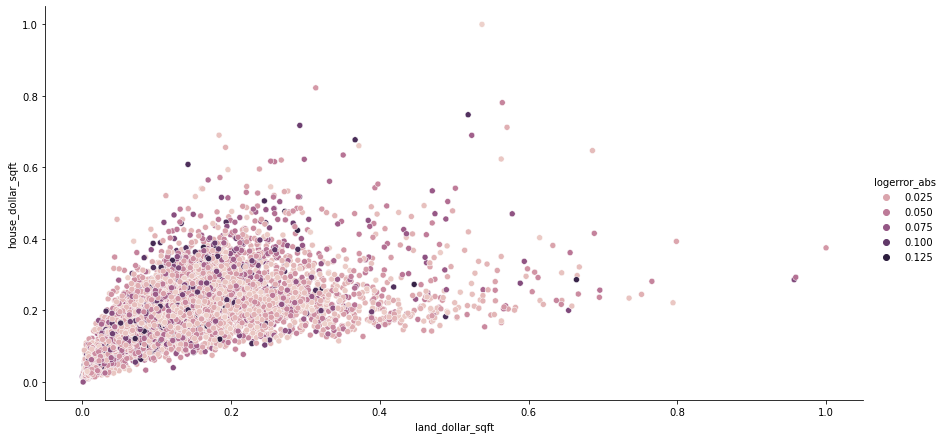

In [137]:
sns.relplot(data=train_scaled, x='land_dollar_sqft', y='house_dollar_sqft', hue= train.logerror_abs, kind='scatter', height=6, aspect=2)

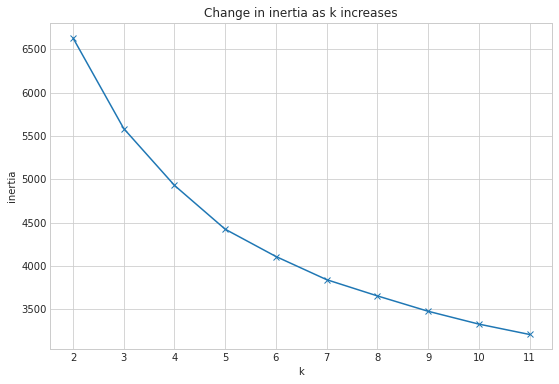

In [138]:
# Use elbow method to see if inertia values support visual exploration
# plot inertia vs k

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k, random_state=123).fit(train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [139]:
# Move forward with k=3
kmeans = KMeans(n_clusters = 6, random_state=123)
kmeans.fit(train_scaled_X)

# And assign the cluster number to a column on the dataframe
train["cluster"] = kmeans.predict(train_scaled_X)
train.head()

bathrooms  bedrooms  house_area    fips  full_baths    latitude  \
7245         2.0       3.0      1214.0  6037.0         2.0  33941146.0   
20215        2.0       3.0      1398.0  6059.0         2.0  33806613.0   
47536        1.0       2.0       864.0  6037.0         1.0  34164721.0   
6815         1.0       3.0      1006.0  6037.0         1.0  33873120.0   
31349        2.0       3.0      1802.0  6037.0         2.0  34114707.0   

         longitude  lot_area land_use_code  city_id  ...  logerror  \
7245  -118219071.0    4692.0          0100  47762.0  ... -0.021805   
20215 -117850438.0    6667.0           122  33252.0  ... -0.006413   
47536 -118159711.0   11266.0          0100  47019.0  ... -0.081616   
6815  -118321763.0    5460.0          0100  54722.0  ... -0.048739   
31349 -117785574.0    9570.0          0100  39308.0  ...  0.001546   

       heating_sys   age  logerror_abs  county  house_dollar_sqft  \
7245    Floor/Wall  77.0      0.021805      LA         201.547776   
20215         None  59.0      0.006413      OC         146.867668   
47536   Floor/Wall  89.0      0.081616      LA         434.027778   
6815    Floor/Wall  69.0      0.048739      LA         226.906561   
31349      Central  40.0      0.001546      LA         305.216426   

       land_dollar_sqft   tax_rate bed_bath_ratio  cluster  
7245          23.466539  40.688882            1.5        2  
20215         18.717114  33.621114            1.5        2  
47536         31.066927   5.495448            2.0        4  
6815          33.447253  16.730565            3.0        2  
31349         37.136886  30.048996            1.5        4  

[5 rows x 27 columns]

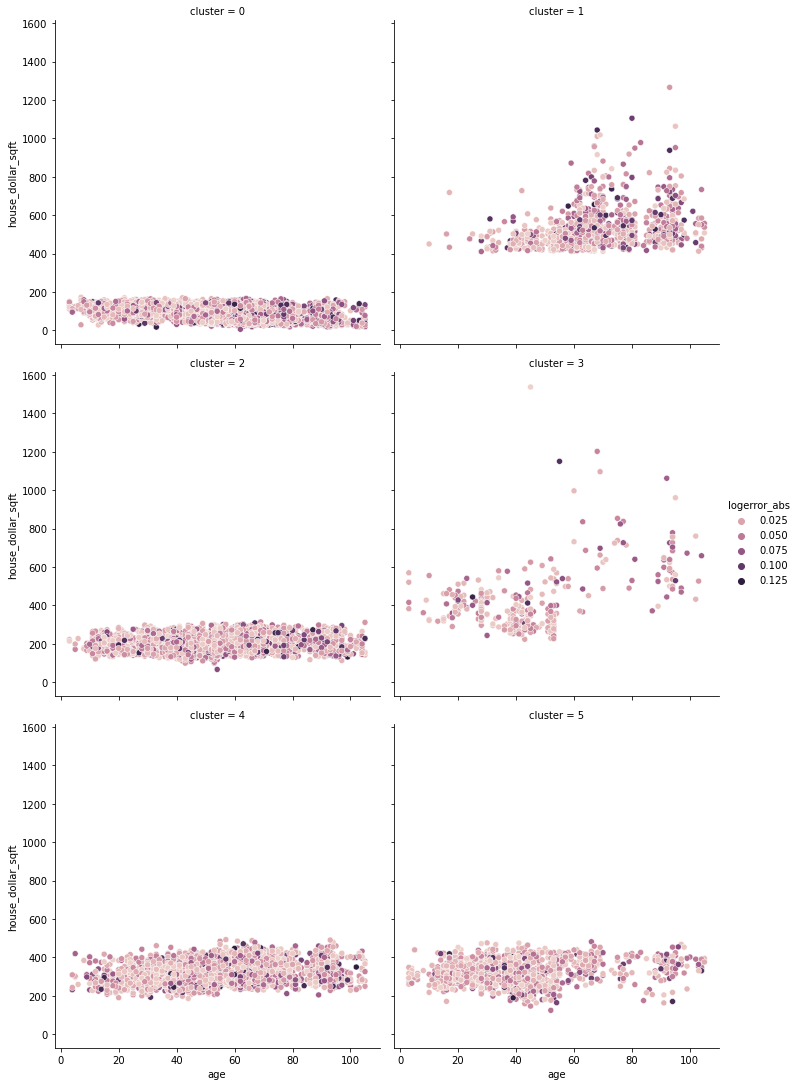

In [140]:
# show house dollar per sqft for age vs log error by cluster
sns.relplot(data=train, x="age", y="house_dollar_sqft", col="cluster", hue='logerror_abs', col_wrap=2)

### Takeaways:
- cluster 0 shows highest log errors

### Check Significant Difference

In [141]:
# check mean of logerror for each cluster
train.groupby(by='cluster').logerror_abs.mean()

cluster
0    0.034335
1    0.035519
2    0.033385
3    0.029615
4    0.030835
5    0.027750
Name: logerror_abs, dtype: float64

In [142]:
# run one sample T-Test
alpha = 0.05
cluster_logerror = train[train.cluster==2].logerror_abs
overall_logerror = train.logerror_abs.mean()

In [143]:
t, p = stats.ttest_1samp(cluster_logerror, overall_logerror)
print(f't={t}, p={p/2}, alpha={alpha}')

t=1.6228219397549961, p=0.05234507042359801, alpha=0.05


# <font color = 'red'> Clustering Combo 3 (Land Dollar Per Sqft and Age)

In [144]:
# Filter columsn from train scaled
cols = ['age', 'land_dollar_sqft']
train_scaled_X = train_scaled[cols]
train_scaled_X.head()

age  land_dollar_sqft
7245   0.725490          0.053175
20215  0.549020          0.042319
47536  0.843137          0.070548
6815   0.647059          0.075988
31349  0.362745          0.084422

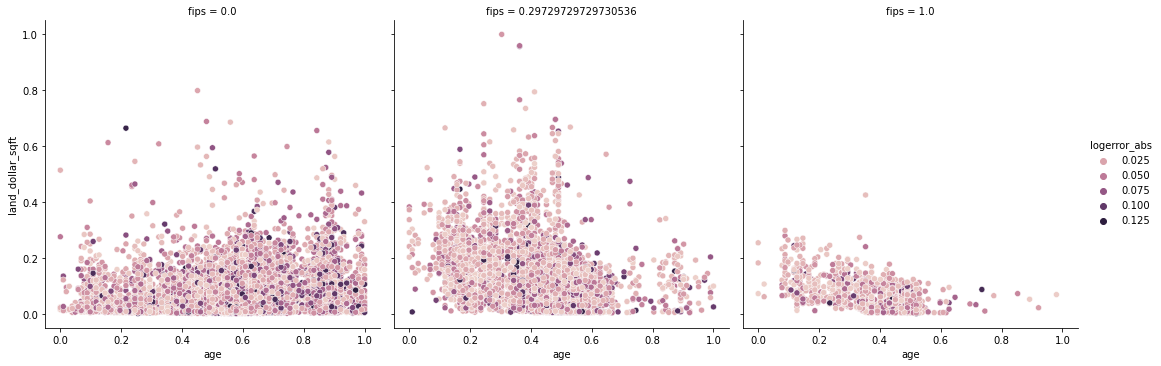

In [145]:
sns.relplot(data=train_scaled, x='age', y='land_dollar_sqft', hue= train.logerror_abs, col='fips', kind='scatter')


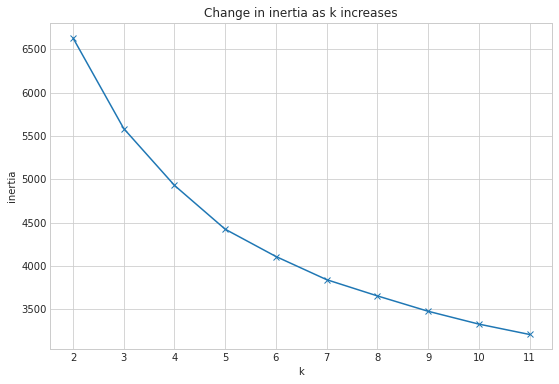

In [146]:
# Use elbow method to see if inertia values support visual exploration
# plot inertia vs k

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k, random_state=123).fit(train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [147]:
# Move forward with k=3
kmeans = KMeans(n_clusters = 6, random_state=123)
kmeans.fit(train_scaled_X)

# And assign the cluster number to a column on the dataframe
train["cluster"] = kmeans.predict(train_scaled_X)
train.head()

bathrooms  bedrooms  house_area    fips  full_baths    latitude  \
7245         2.0       3.0      1214.0  6037.0         2.0  33941146.0   
20215        2.0       3.0      1398.0  6059.0         2.0  33806613.0   
47536        1.0       2.0       864.0  6037.0         1.0  34164721.0   
6815         1.0       3.0      1006.0  6037.0         1.0  33873120.0   
31349        2.0       3.0      1802.0  6037.0         2.0  34114707.0   

         longitude  lot_area land_use_code  city_id  ...  logerror  \
7245  -118219071.0    4692.0          0100  47762.0  ... -0.021805   
20215 -117850438.0    6667.0           122  33252.0  ... -0.006413   
47536 -118159711.0   11266.0          0100  47019.0  ... -0.081616   
6815  -118321763.0    5460.0          0100  54722.0  ... -0.048739   
31349 -117785574.0    9570.0          0100  39308.0  ...  0.001546   

       heating_sys   age  logerror_abs  county  house_dollar_sqft  \
7245    Floor/Wall  77.0      0.021805      LA         201.547776   
20215         None  59.0      0.006413      OC         146.867668   
47536   Floor/Wall  89.0      0.081616      LA         434.027778   
6815    Floor/Wall  69.0      0.048739      LA         226.906561   
31349      Central  40.0      0.001546      LA         305.216426   

       land_dollar_sqft   tax_rate bed_bath_ratio  cluster  
7245          23.466539  40.688882            1.5        0  
20215         18.717114  33.621114            1.5        3  
47536         31.066927   5.495448            2.0        5  
6815          33.447253  16.730565            3.0        0  
31349         37.136886  30.048996            1.5        1  

[5 rows x 27 columns]

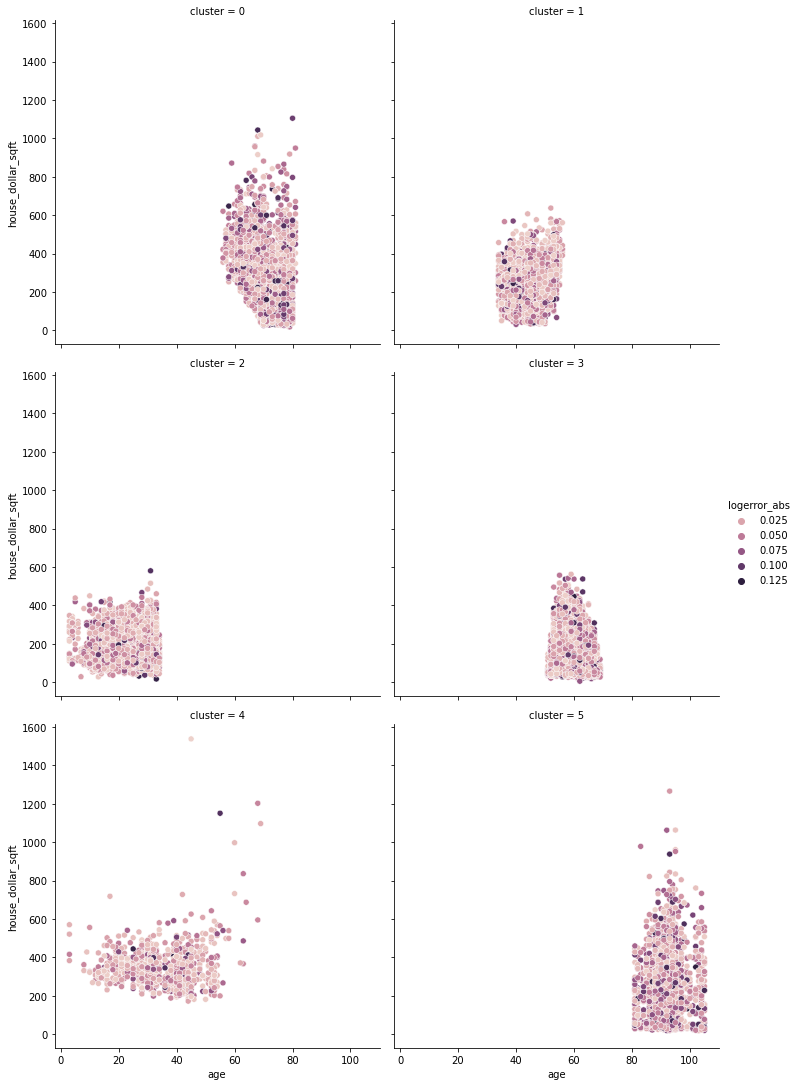

In [148]:
# show house dollar per sqft for age vs log error by cluster
sns.relplot(data=train, x="age", y="house_dollar_sqft", col="cluster", hue='logerror_abs', col_wrap=2)

### Takeaways:
- cluster 3 shows highest log errors

### Check Significant Difference

In [149]:
# check mean of logerror for each cluster
train.groupby(by='cluster').logerror_abs.mean()

cluster
0    0.035341
1    0.030874
2    0.026750
3    0.034135
4    0.026198
5    0.040080
Name: logerror_abs, dtype: float64

In [150]:
# run one sample T-Test
alpha = 0.05
cluster_logerror = train[train.cluster==3].logerror_abs
overall_logerror = train.logerror_abs.mean()

t, p = stats.ttest_1samp(cluster_logerror, overall_logerror)
print(f't={t}, p={p/2}, alpha={alpha}')

t=3.5730995736845013, p=0.00017797397375737546, alpha=0.05


## Takeaway from Clustering
- Clustering 1 show largest differnce of log error

# <font color = 'red'> Clustering Combo 4 (longitude and lattitude)

In [152]:
# Filter columsn from train scaled
cols = ['longitude', 'latitude']
train_scaled_X = train_scaled[cols]
train_scaled_X.head()

longitude  latitude
7245    0.567711  0.412765
20215   0.814525  0.311107
47536   0.607455  0.581707
6815    0.498955  0.361362
31349   0.857954  0.543914

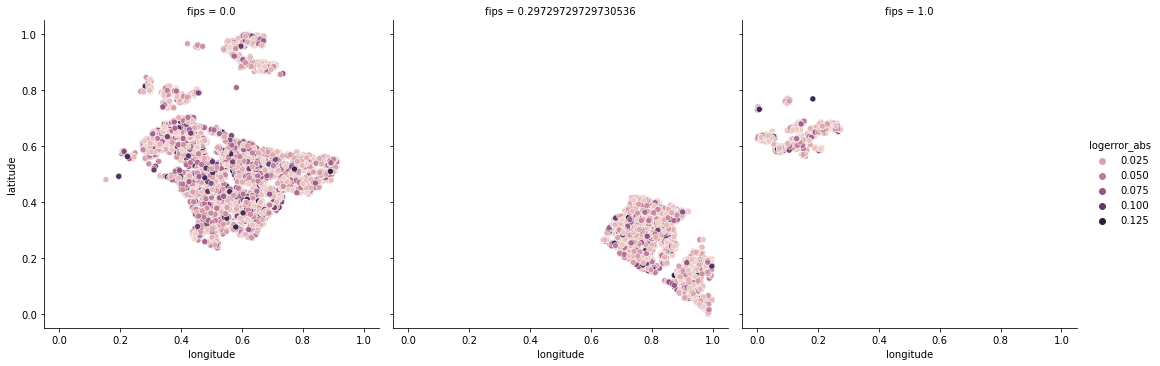

In [196]:
sns.relplot(data=train_scaled, x='longitude', y='latitude', hue= train.logerror_abs, col='fips', kind='scatter')

Text(0.5, 1.0, 'Change in inertia as k increases')

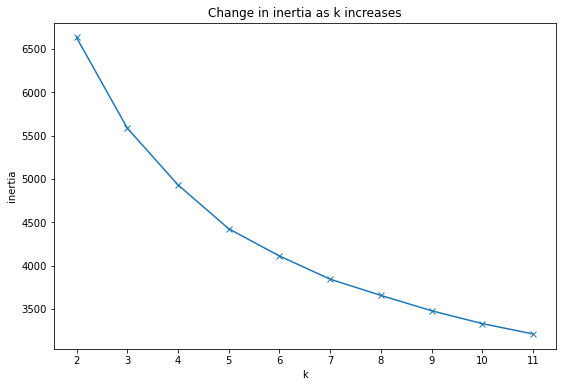

In [154]:
# Use elbow method to see if inertia values support visual exploration
# plot inertia vs k with plt.style.context('seaborn-whitegrid'):
plt.figure(figsize=(9, 6))
pd.Series({k: KMeans(k, random_state=123).fit(train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
plt.xticks(range(2, 12))
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Change in inertia as k increases')

In [197]:
# Move forward with k=5
kmeans = KMeans(n_clusters = 5, random_state=123)
kmeans.fit(train_scaled_X)

KMeans(n_clusters=5, random_state=123)

In [198]:
# And assign the cluster number to a column on the dataframe
train["cluster"] = kmeans.predict(train_scaled_X)
train.head()

bathrooms  bedrooms  house_area    fips  full_baths    latitude  \
7245         2.0       3.0      1214.0  6037.0         2.0  33941146.0   
20215        2.0       3.0      1398.0  6059.0         2.0  33806613.0   
47536        1.0       2.0       864.0  6037.0         1.0  34164721.0   
6815         1.0       3.0      1006.0  6037.0         1.0  33873120.0   
31349        2.0       3.0      1802.0  6037.0         2.0  34114707.0   

         longitude  lot_area land_use_code  city_id  ...   age  logerror_abs  \
7245  -118219071.0    4692.0          0100  47762.0  ...  77.0      0.021805   
20215 -117850438.0    6667.0           122  33252.0  ...  59.0      0.006413   
47536 -118159711.0   11266.0          0100  47019.0  ...  89.0      0.081616   
6815  -118321763.0    5460.0          0100  54722.0  ...  69.0      0.048739   
31349 -117785574.0    9570.0          0100  39308.0  ...  40.0      0.001546   

       county  house_dollar_sqft  land_dollar_sqft   tax_rate  bed_bath_ratio  \
7245       LA         201.547776         23.466539  40.688882             1.5   
20215      OC         146.867668         18.717114  33.621114             1.5   
47536      LA         434.027778         31.066927   5.495448             2.0   
6815       LA         226.906561         33.447253  16.730565             3.0   
31349      LA         305.216426         37.136886  30.048996             1.5   

       cluster cluster_1  cluster_2  
7245         2         0          1  
20215        3         0          0  
47536        2         0          1  
6815         3         0          0  
31349        0         1          0  

[5 rows x 29 columns]

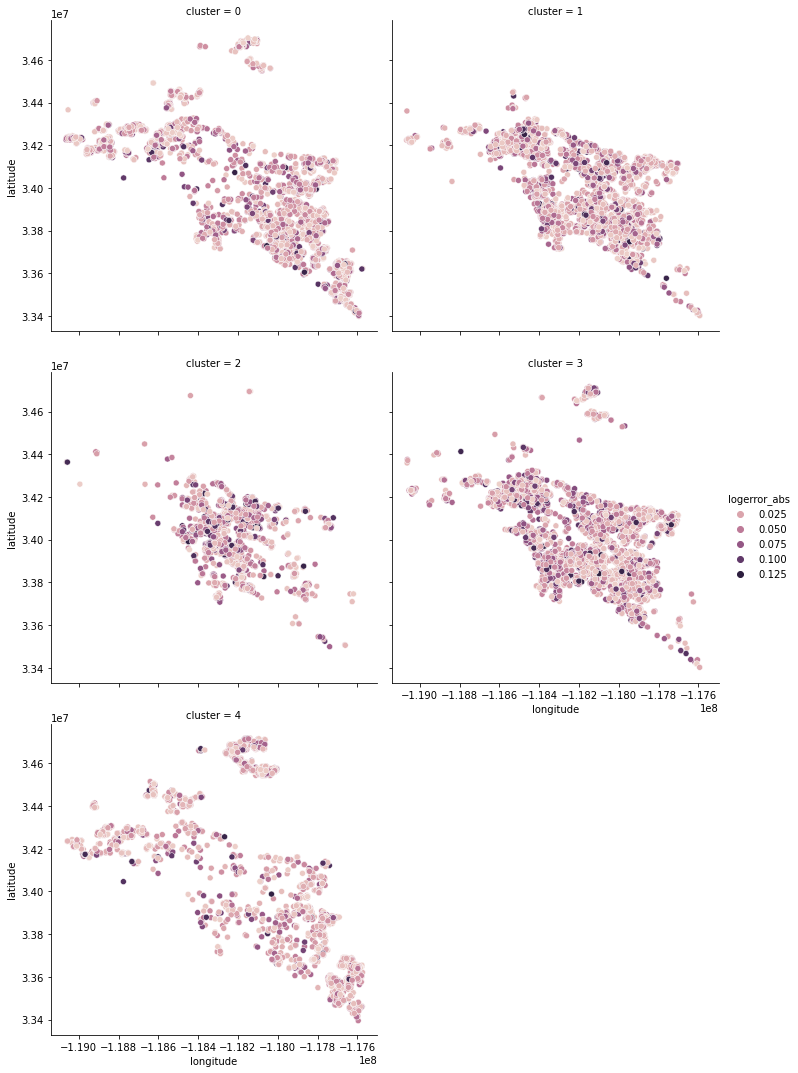

In [199]:
# show house dollar per sqft for age vs log error by cluster
sns.relplot(data=train, x="longitude", y="latitude", col="cluster", hue='logerror_abs', col_wrap=2)

### Takeaways:
- cluster 3 shows highest log errors

### Check Significant Difference

In [200]:
# check mean of logerror for each cluster
train.groupby(by='cluster').logerror_abs.mean()

cluster
0    0.030726
1    0.032601
2    0.039709
3    0.036005
4    0.026425
Name: logerror_abs, dtype: float64

In [ ]:
# run one sample T-Test
alpha = 0.05
cluster_logerror = train[train.cluster==3].logerror_abs
overall_logerror = train.logerror_abs.mean()

t, p = stats.ttest_1samp(cluster_logerror, overall_logerror)
print(f't={t}, p={p/2}, alpha={alpha}')

## Takeaway from Clustering
- Clustering 1 show largest differnce of log error

## Move Forward with Cluster 1 in Modeling (Features: house

In [157]:
# Filter columns from train scaled to set cluster features
cols = ['age', 'house_dollar_sqft']
train_scaled_X = train_scaled[cols]
validate_scaled_X = validate_scaled[cols]
test_scaled_X = test_scaled[cols]

# Move forward with 3 clusters and fit kmeans to train_scaled
kmeans = KMeans(n_clusters = 3, random_state=123)
kmeans.fit(train_scaled_X)

# And assign the cluster number to a column on the dataframe
train["cluster"] = kmeans.predict(train_scaled_X)
validate["cluster"] = kmeans.predict(validate_scaled_X)
test["cluster"] = kmeans.predict(test_scaled_X)

# <font color = 'red'> Prep for Modeling

In [158]:
# hot one encode for cluster column using get_dummies for train, validate, test
df_dummies_train = pd.get_dummies(data=train.cluster, prefix='cluster', drop_first=True)
df_dummies_validate = pd.get_dummies(data=validate.cluster, prefix='cluster', drop_first=True)
df_dummies_test = pd.get_dummies(data=test.cluster, prefix='cluster', drop_first=True)

df_dummies_train.head()

cluster_1  cluster_2
7245           0          1
20215          0          0
47536          0          1
6815           0          0
31349          1          0

In [159]:
# concat df_dummies with train on columns
train = pd.concat([train, df_dummies_train], axis=1)
validate = pd.concat([validate, df_dummies_validate], axis=1)
test = pd.concat([test, df_dummies_test], axis=1)

train.head()

bathrooms  bedrooms  house_area    fips  full_baths    latitude  \
7245         2.0       3.0      1214.0  6037.0         2.0  33941146.0   
20215        2.0       3.0      1398.0  6059.0         2.0  33806613.0   
47536        1.0       2.0       864.0  6037.0         1.0  34164721.0   
6815         1.0       3.0      1006.0  6037.0         1.0  33873120.0   
31349        2.0       3.0      1802.0  6037.0         2.0  34114707.0   

         longitude  lot_area land_use_code  city_id  ...   age  logerror_abs  \
7245  -118219071.0    4692.0          0100  47762.0  ...  77.0      0.021805   
20215 -117850438.0    6667.0           122  33252.0  ...  59.0      0.006413   
47536 -118159711.0   11266.0          0100  47019.0  ...  89.0      0.081616   
6815  -118321763.0    5460.0          0100  54722.0  ...  69.0      0.048739   
31349 -117785574.0    9570.0          0100  39308.0  ...  40.0      0.001546   

       county  house_dollar_sqft  land_dollar_sqft   tax_rate  bed_bath_ratio  \
7245       LA         201.547776         23.466539  40.688882             1.5   
20215      OC         146.867668         18.717114  33.621114             1.5   
47536      LA         434.027778         31.066927   5.495448             2.0   
6815       LA         226.906561         33.447253  16.730565             3.0   
31349      LA         305.216426         37.136886  30.048996             1.5   

       cluster cluster_1  cluster_2  
7245         2         0          1  
20215        0         0          0  
47536        2         0          1  
6815         0         0          0  
31349        1         1          0  

[5 rows x 29 columns]

## <font color = 'red'>Select Columns

In [160]:
# select columns to model
cols = ['land_dollar_sqft','house_dollar_sqft', 'age', 'logerror_abs']

## <font color = 'red'> Create y_train and X_train sets

In [161]:
# establish target column
target = 'logerror_abs'

# create X & y version of train, validate, test with y the target and X are the features. 
X_train = train[cols].drop(columns=[target])
y_train = train[target]

X_validate = validate[cols].drop(columns=[target])
y_validate = validate[target]

X_test = test[cols].drop(columns=[target])
y_test = test[target]

In [162]:
X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

((17614, 3), (7550, 3), (6292, 3), (17614,), (7550,), (6292,))

## <font color = 'red'> Scale for Modeling

In [163]:
# Create the scale container
scaler = sklearn.preprocessing.MinMaxScaler()


# Fit the scaler to the features
scaler.fit(X_train)

# create scaled X versions 
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

# Convert numpy array to pandas dataframe for feature Engineering
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns.to_list())
X_validate_scaled = pd.DataFrame(X_validate_scaled, index=X_validate.index, columns=X_validate.columns.to_list())
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns.to_list())

In [164]:
X_train_scaled.head()

land_dollar_sqft  house_dollar_sqft       age
7245           0.053175           0.127935  0.725490
20215          0.042319           0.092248  0.549020
47536          0.070548           0.279664  0.843137
6815           0.075988           0.144486  0.647059
31349          0.084422           0.195595  0.362745

## <font color = 'red'> Feature Engineering

### Use Select K Best to find 3 Best Features


In [165]:
from sklearn.feature_selection import SelectKBest, f_regression

# Use f_regression stats test each column to find best 3 features
f_selector = SelectKBest(f_regression, k=3)

# find tthe best correlations with y
f_selector.fit(X_train_scaled, y_train)

# Creaet boolean mask of the selected columns. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

f_feature

['land_dollar_sqft', 'house_dollar_sqft', 'age']

### Note:
- Select K Best selected area, year_built, and bathrooms.

### Use Recursive Feature Elemination to select 3 best features

In [166]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# create the ML algorithm container
lm = LinearRegression()

# create the rfe container with the the number of features I want. 
rfe = RFE(lm, n_features_to_select=3)

# fit RFE to the data
rfe.fit(X_train_scaled,y_train)  

# get the mask of the selected columns
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

rfe_feature

['land_dollar_sqft', 'house_dollar_sqft', 'age']

### Notes:
- RFE Select 3 Best Columns: area, latitude, longitude
- RFE Selects 3 best columns:land_dollar_sqft, house_dollar_sqft, age



In [167]:
X_train_scaled.head()

land_dollar_sqft  house_dollar_sqft       age
7245           0.053175           0.127935  0.725490
20215          0.042319           0.092248  0.549020
47536          0.070548           0.279664  0.843137
6815           0.075988           0.144486  0.647059
31349          0.084422           0.195595  0.362745

In [168]:
# Remove Features before Modeling
# X_train_scaled = X_train_scaled.drop(columns=['pools','lot_size','bedrooms','bathrooms'])
# X_validate_scaled = X_validate_scaled.drop(columns=['pools','lot_size','bedrooms','bathrooms'])
# X_test_scaled = X_test_scaled.drop(columns=['pools','lot_size','bedrooms','bathrooms'])

# <font color = 'red'>Modeling

## Create Baseline & Evaluate with RMSE

In [169]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)
y_train.head()

logerror_abs
7245       0.021805
20215      0.006413
47536      0.081616
6815       0.048739
31349      0.001546

In [170]:
# Add target mean column as baseline check
y_train['mean_pred'] = y_train.logerror_abs.mean()
y_validate['mean_pred'] = y_validate.logerror_abs.mean()

# add target median column as baseline check
y_train['median_pred'] = y_train.logerror_abs.median()
y_validate['median_pred'] = y_validate.logerror_abs.median()

In [171]:
# Create Baseline RMSE of target mean
rmse_train = mean_squared_error(y_train.logerror_abs, y_train.mean_pred) ** .5
rmse_validate = mean_squared_error(y_validate.logerror_abs, y_validate.mean_pred) ** .5

In [172]:
# Show RMSE Score for train and validate
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.03 
Validate/Out-of-Sample:  0.03


In [173]:
# Create Baseline RMSE of target median
rmse_train = mean_squared_error(y_train.logerror_abs, y_train.median_pred) ** .5
rmse_validate = mean_squared_error(y_validate.logerror_abs, y_validate.median_pred) ** .5

In [174]:
# Show RMSE Score for train and validate
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  0.03 
Validate/Out-of-Sample:  0.03


### Notes:
- Mean Baseline RMSE (.03) is same as Median Baseline RMSE (.03)
- Going Forward with Mean for Baseline

### Create Metric Holder

In [175]:
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate,
                'RMSE_test:': 'none',
                'RMSE_diff:': rmse_train - rmse_validate
                }
            ])

In [176]:
metric_df

model  RMSE_train  RMSE_validate RMSE_test:  RMSE_diff:
0  mean_baseline    0.028511       0.028382       none    0.000128

## <font color = 'red'> Develop Models 

### Create Model 1 - Linear Regression (OLS) without Clusters

In [177]:
# create, fit, predict ols model for train and validate
ols = LinearRegression()
ols.fit(X_train_scaled, y_train.logerror_abs)
# predict for train
y_train['ols_pred_wo_cluster'] = ols.predict(X_train_scaled)
# predict validate
y_validate['ols_pred_wo_cluster'] = ols.predict(X_validate_scaled)

In [178]:
ols.coef_

array([-0.00320841, -0.0106081 ,  0.02050053])

In [179]:
y_train.head()

logerror_abs  mean_pred  median_pred  ols_pred_wo_cluster
7245       0.021805   0.032749     0.025032             0.037457
20215      0.006413   0.032749     0.025032             0.034253
47536      0.081616   0.032749     0.025032             0.038204
6815       0.048739   0.032749     0.025032             0.035601
31349      0.001546   0.032749     0.025032             0.029203

In [180]:
X_train.head()

land_dollar_sqft  house_dollar_sqft   age
7245          23.466539         201.547776  77.0
20215         18.717114         146.867668  59.0
47536         31.066927         434.027778  89.0
6815          33.447253         226.906561  69.0
31349         37.136886         305.216426  40.0

In [181]:
# evaluate rmse of train
rmse_train = mean_squared_error(y_train.logerror_abs, y_train.ols_pred_wo_cluster) ** .5

# evaluate rmse of validate
rmse_validate = mean_squared_error(y_validate.logerror_abs, y_validate.ols_pred_wo_cluster) ** .5

In [182]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.02712974396694978 
Validation/Out-of-Sample:  0.027103528466771193


In [183]:
# add to eval to metric holder
metric_df = metric_df.append({
    'model': 'ols_egressor_wo_cluster', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    'RMSE_test:': 'none',
    'RMSE_diff:': rmse_train - rmse_validate
    }, ignore_index=True)

In [184]:
metric_df

model  RMSE_train  RMSE_validate RMSE_test:  RMSE_diff:
0            mean_baseline    0.028511       0.028382       none    0.000128
1  ols_egressor_wo_cluster    0.027130       0.027104       none    0.000026

In [185]:
y_train.head()

logerror_abs  mean_pred  median_pred  ols_pred_wo_cluster
7245       0.021805   0.032749     0.025032             0.037457
20215      0.006413   0.032749     0.025032             0.034253
47536      0.081616   0.032749     0.025032             0.038204
6815       0.048739   0.032749     0.025032             0.035601
31349      0.001546   0.032749     0.025032             0.029203

### Create Model 2: Linear Regression (OLS) with Cluster Columns

In [186]:
# select columns to model including cluster columns
cols = ['land_dollar_sqft','house_dollar_sqft', 'age', 'logerror_abs', 'cluster_1', 'cluster_2']

In [187]:
# establish target column
target = 'logerror_abs'

# create X & y version of train, validate, test with y the target and X are the features. 
X_train = train[cols].drop(columns=[target])

X_validate = validate[cols].drop(columns=[target])

X_test = test[cols].drop(columns=[target])

In [188]:
# Create the scale container
scaler = sklearn.preprocessing.MinMaxScaler()


# Fit the scaler to the features
scaler.fit(X_train)

# create scaled X versions 
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

# Convert numpy array to pandas dataframe for feature Engineering
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns.to_list())
X_validate_scaled = pd.DataFrame(X_validate_scaled, index=X_validate.index, columns=X_validate.columns.to_list())
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns.to_list())

In [189]:
# create, fit, predict ols model for train and validate
ols = LinearRegression()
ols.fit(X_train_scaled, y_train.logerror_abs)

# predict on train
y_train['ols_pred_w_cluster'] = ols.predict(X_train_scaled)

# predict validate
y_validate['ols_pred_w_cluster'] = ols.predict(X_validate_scaled)

In [190]:
# evaluate rmse for train
rmse_train = mean_squared_error(y_train.logerror_abs, y_train.ols_pred_w_cluster) ** .5

# evaluate rmse for validate
rmse_validate = mean_squared_error(y_validate.logerror_abs, y_validate.ols_pred_w_cluster) ** .5

In [191]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.027125700117992747 
Validation/Out-of-Sample:  0.02709538521451423


In [192]:
# add to eval to metric holder
metric_df = metric_df.append({
    'model': 'ols_egressor_w_cluster', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    'RMSE_test:': 'none',
    'RMSE_diff:': rmse_train - rmse_validate
    }, ignore_index=True)

In [193]:
metric_df

model  RMSE_train  RMSE_validate RMSE_test:  RMSE_diff:
0            mean_baseline    0.028511       0.028382       none    0.000128
1  ols_egressor_wo_cluster    0.027130       0.027104       none    0.000026
2   ols_egressor_w_cluster    0.027126       0.027095       none    0.000030

### Takeaways:
- With clusters did worse

###  Create Model 3: Linear Regression (OLS) with Clusters and More Features

In [194]:
# select columns to model including cluster columns
cols = ['land_dollar_sqft','house_dollar_sqft', 'age', 'logerror_abs', 'cluster_1', 'cluster_2', 'longitude',
       'latitude','bed_bath_ration','tax_rate']

In [195]:
# establish target column
target = 'logerror_abs'

# create X & y version of train, validate, test with y the target and X are the features. 
X_train = train[cols].drop(columns=[target])

X_validate = validate[cols].drop(columns=[target])

X_test = test[cols].drop(columns=[target])

KeyError: "['bed_bath_ration'] not in index"

In [ ]:
# Create the scale container
scaler = sklearn.preprocessing.MinMaxScaler()


# Fit the scaler to the features
scaler.fit(X_train)

# create scaled X versions 
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

# Convert numpy array to pandas dataframe for feature Engineering
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns.to_list())
X_validate_scaled = pd.DataFrame(X_validate_scaled, index=X_validate.index, columns=X_validate.columns.to_list())
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns.to_list())

In [ ]:
# create, fit, predict ols model for train and validate
ols = LinearRegression()
ols.fit(X_train_scaled, y_train.logerror_abs)

# predict on train
y_train['ols_pred_w_cluster_and_features'] = ols.predict(X_train_scaled)

# predict validate
y_validate['ols_pred_w_cluster_and_features'] = ols.predict(X_validate_scaled)

In [ ]:
# evaluate rmse for train
rmse_train = mean_squared_error(y_train.logerror_abs, y_train.ols_pred_w_cluster_and_features) ** .5

# evaluate rmse for validate
rmse_validate = mean_squared_error(y_validate.logerror_abs, y_validate.ols_pred_w_cluster_and_features) ** .5

In [ ]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
# add to eval to metric holder
metric_df = metric_df.append({
    'model': 'ols_egressor_w_cluster_and_features', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    'RMSE_test:': 'none',
    'RMSE_diff:': rmse_train - rmse_validate
    }, ignore_index=True)

In [ ]:
metric_df

### Takeaways:
- ???

### Create Model 4 - Polynomial Regression with Clusters and More Features

In [ ]:
# create polynomial features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled to new sets
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 =  pf.transform(X_test_scaled)

In [ ]:
# create the model object
osl2 = LinearRegression()

# fit the model train data. Specify y_train columns since it was converted to dataframe  
osl2.fit(X_train_degree2, y_train.logerror_abs)

# predict train
y_train['pr_pred'] = osl2.predict(X_train_degree2)

# create rmse
rmse_train = mean_squared_error(y_train.logerror_abs, y_train.pr_pred) ** .5

# predict validate
y_validate['pr_pred'] = osl2.predict(X_validate_degree2)

# evaluate rmse
rmse_validate = mean_squared_error(y_validate.logerror_abs, y_validate.pr_pred) ** .5

In [ ]:
print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
# add to metric holder
metric_df = metric_df.append({
    'model': 'PolynomialRegressor', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    'RMSE_test:': 'none',
    'RMSE_diff:': rmse_train - rmse_validate
    }, ignore_index=True)

In [ ]:
metric_df

## <font color = 'red' > Evaluate
    
### Plotting Actual vs Predicted Values

In [ ]:
plt.figure(figsize=(16,8))

#Basline
plt.plot(y_validate.logerror_abs, y_validate.mean_pred, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (0,.034))

# Ideal Line
plt.plot(y_validate.logerror_abs, y_validate.logerror_abs, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (0.005, 0), rotation=27)

# Model 1: OLS without Clusters
plt.scatter(y_validate.logerror_abs, y_validate.ols_pred_wo_cluster, 
            alpha=.5, color="red", s=10, label="Model 1: OLS wo Clusters")

# Model 2: OlS with Clusters
plt.scatter(y_validate.logerror_abs, y_validate.ols_pred_w_cluster, 
            alpha=.5, color="yellow", s=10, label="Model 2: OLS w Clusters")

# Model 3: OLS with Clusters and More Features
plt.scatter(y_validate.logerror_abs, y_validate.ols_pred_w_cluster_and_features, 
            alpha=.5, color="green", s=10, label="Model 3: OLS w Clusters and More Features")

# Model 4: Polynomial Regresion with Clusters and More Features
plt.scatter(y_validate.logerror_abs, y_validate.pr_pred, 
            alpha=.5, color="brown", s=10, label="Model 4: Poly Regression with Clusters and More Features")



plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
# plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Notes:
- ????

### Residual Plots: Plotting the Errors in Predictions

In [ ]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.annotate("Line of No Error", (0, -.01))
plt.scatter(y_validate.logerror_abs, y_validate.ols_pred_wo_cluster - y_validate.logerror_abs, 
            alpha=.5, color="red", s=10, label="Model: OLS without Cluster")
plt.scatter(y_validate.logerror_abs, y_validate.ols_pred_w_cluster - y_validate.logerror_abs, 
            alpha=.5, color="yellow", s=10, label="Mode2: OLS with Cluster")
plt.scatter(y_validate.logerror_abs, y_validate.ols_pred_w_cluster_and_features - y_validate.logerror_abs, 
            alpha=.5, color="green", s=10, label="Model 3: OLS with Cluster and More Features")
plt.scatter(y_validate.logerror_abs, y_validate.pr_pred - y_validate.logerror_abs, 
            alpha=.5, color="green", s=10, label="Model 4: Poly Regressor with Cluster and More Features")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value")
# plt.title("Do the size of errors change as the actual value changes?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Notes:
- ???

### Histograms of Actuals vs Predicted Values

In [ ]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.logerror_abs, color='blue', alpha=.5, label="Absolute Value of Log Errors")
plt.hist(y_validate.ols_pred_wo_cluster, color='red', alpha=.5, label="Model 1: OLS without Clusters")
plt.hist(y_validate.ols_pred_w_cluster, color='yellow', alpha=.5, label="Model2: OLS with Clusters")
plt.hist(y_validate.ols_pred_w_cluster_and_features, color='green', alpha=.5, label="Model 3: OLS with Cluster and More Features")
plt.hist(y_validate.pr_pred, color='green', alpha=.5, label="Model 4: Poly Regressor with Clusters and More Features")
plt.xlabel("ABS LogError Values")
plt.ylabel("Number of Homes ")
plt.title("Comparing the Distribution of Actual ABS Log Error to Distributions of Predicted ABS Log Error for Models")
plt.legend()
plt.show()

### Notes:
- Models capture most of actual values distribution but miss the lower valued homes

## Model Selection and Out-of-Sample Evaluatoin

In [ ]:
# predict train
y_test['pr_pred'] = osl2.predict(X_test_degree2)

# create rmse
rmse_test = mean_squared_error(y_test.logerror_abs, y_test.pr_pred) ** .5

print("RMSE for Polynomial Model, degrees=2\nTest/Out-of-Sample: ", rmse_test)# add to metric holder

In [ ]:
# add to metric holder
metric_df = metric_df.append({
    'model': 'PolynomialRegressor', 
    'RMSE_train': 'none',
    'RMSE_validate': 'none',
    'RMSE_test:': rmse_test,
    'RMSE_diff:': rmse_train - rmse_test
    }, ignore_index=True)

In [ ]:
metric_df

### Notes:
- Polynomial Model RMSE is 18.6M indicating wrong model to use and/or overfit

# <font color = 'red'> Conclusion

## Summary
- 

## Recommendations
- ???

## Conclusion
- ???

### Project Description

- A model that predicts property tax assessed values of single family properties based on 2017 transactions.
- Identify ways to make a better model for Zillow.
- Create new features out of existing features.
- Try non-linear regression model or try a model for each count

Deliver:
1. Github Repo
    - README.md
    - Final Report
    - Working Notebooks
    - Acquire and Prepare Modules
    - Misc Artifacts
1. Regression Model (Linear or Non-Linear)
2. Final Notebook with Recommendation
    - 4 Visuals, 2 with stats tests
        - Data Context of Target Variable (Distribution of values)
    - 3 Best Models (show steps/code to fit/eval/select)
    - Visual of how best Model performed
3. Working Notebook:
    - Reproducible comments
    - Exploration with at least two stats test during exploration
5. Presentation
    - Findings
    - Methodologies
    - Conclusions

### Initial Questions

- What are the transactions are in 2017?
- What states and counties are the properties located in?
- What is the tax rate per county or fips? (might have to combine columns to calcualate)
- What is the distribution of tax rates for each county?
- What is the distribution of taxes across fips?
- What are the drivers of single family property values?
- Why do some properties have a much higher value than others when they are located so close to each other?
- Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? 
- Is having 1 bathroom worse than having 2 bedrooms?